# Modeling with k-means, Part 3

In this notebook I investigate how well the k-means algorithm distinguishes between the INLAND California housing districts and the districts closer to the ocean.  The INLAND districts are already identified as such.  I start with 11 predictors.  The longitude and latitude variables are removed in order to make the challenge meaningful.  Variables remaining include, among others, the median house value of each district, the median housing age of a district, the population per household in the district, and so forth.  For more information on this dataset, see my CA housing analysis project.  (This project involves a set of Jupyter notebooks.  See the AnalyzeCAhousingData repository.)

As with the downer cow dataset, I want to see whether we can construct a better classification model using k-means in combination with one or more supervised learning algoritms.  Applying weights to the variables in this dataset will be more difficult because there are more variables to work with and quite a bit more data, so finding the optimal weights will take some computing power.



                                      * * * * * 

# Preliminaries

In [ ]:
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(parallel)
require(faraway)
require(randomForest)
require(gbm)
require(plyr)
require(e1071)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


## Construct training and test sets

In [3]:
traindat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/R_train_Part02-2_Step5.csv",
                  header = T, row.names= 1, colClasses= c("character", rep("numeric", 9), rep("character", 2), 
                                rep("numeric", 4), "character", "numeric", "character"))
dim(traindat)


[1] 16308    18

In [4]:
colnames(traindat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "HHdensity"          "HHdens_ln"         
[13] "rooms_per_hh"       "bdrms_per_room"     "pop_per_hh"        
[16] "op_transf"          "long_transf"        "income_cat"

In [22]:
table(as.factor(traindat$op_transf))



  INLAND NEAR BAY    OCEAN 
    5172     1816     9320 

In [23]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/R_test_Part02-2_Step5.csv",
                    header = T, row.names= 1,
                    colClasses= c("character", rep("numeric", 9), 
                                  rep("character", 2), rep("numeric", 4),
                                  "character", "numeric", "character"))
dim(testdat)


[1] 3888   18

In [24]:
colnames(testdat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "HHdensity"          "HHdens_ln"         
[13] "rooms_per_hh"       "bdrms_per_room"     "pop_per_hh"        
[16] "op_transf"          "long_transf"        "income_cat"

In [25]:
dat <- rbind(traindat, testdat)
dim(dat)
table(as.factor(dat$op_transf))


[1] 20196    18


  INLAND NEAR BAY    OCEAN 
    6467     2235    11494 

In [26]:
dat$Inland <- 0
dat[which(dat$op_transf== "INLAND"),]$Inland <- 1
table(dat$Inland)



    0     1 
13729  6467 

In [27]:
newcols <- colnames(dat)[which(!(colnames(dat) %in% c("HHdensity", "income_cat",
                                                     "ocean_proximity", "op_transf")))]
newcols


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "long_transf"        "Inland"

In [28]:
dat <- dat[, newcols]
dim(dat)
colnames(dat)


[1] 20196    15

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "long_transf"        "Inland"

In [29]:
# Create training and test sets for use in testing
# new k-means approach. 

set.seed(8763)
smp <- sample(rownames(dat), 10196, replace=FALSE)
traindat <- dat[smp,]
testdat <- dat[which(!(rownames(dat) %in% smp)),]
dim(testdat)


[1] 10000    15

In [30]:
rm(dat)


In [31]:
# Remove latitude, longitude, and long_transf from
# both traindat and testdat.  If these variables 
# remained in the dataset, it would be far too easy
# to distinguish between the inland and oceanside 
# districts.  

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("latitude","longitude","long_transf")))]
newcols


[1] "housing_median_age" "total_rooms"        "total_bedrooms"    
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "HHdens_ln"          "rooms_per_hh"      
[10] "bdrms_per_room"     "pop_per_hh"         "Inland"

In [32]:
traindat <- traindat[, newcols]
testdat <- testdat[, newcols]
dim(traindat)


[1] 10196    12

In [33]:
# Move the response variable, Inland, to the first
# column.

newcols <- colnames(traindat)
newcols <- newcols[which(!(newcols %in% c("Inland")))]
newcols <- c("Inland", newcols)
newcols


[1] "Inland"             "housing_median_age" "total_rooms"       
 [4] "total_bedrooms"     "population"         "households"        
 [7] "median_income"      "median_house_value" "HHdens_ln"         
[10] "rooms_per_hh"       "bdrms_per_room"     "pop_per_hh"

In [34]:
traindat <- traindat[, newcols]
testdat <- testdat[, newcols]


In [35]:
# Save out the files.

write.csv(traindat, file="/home/greg/Documents/stat/github_repos/cows/CAhousing_train_10196.csv",
          row.names= TRUE)

write.csv(testdat, file="/home/greg/Documents/stat/github_repos/cows/CAhousing_test_10K.csv",
          row.names= TRUE)


In [5]:
traindat <- read.csv("/home/greg/Documents/stat/github_repos/cows/CAhousing_train_10196.csv",
                    header=TRUE, row.names=1, colClasses= c("character", rep("numeric",12)))
dim(traindat)


[1] 10196    12

In [6]:
testdat <- read.csv("/home/greg/Documents/stat/github_repos/cows/CAhousing_test_10K.csv",
                    header=TRUE, row.names=1, colClasses= c("character", rep("numeric",12)))
dim(testdat)


[1] 10000    12

In [5]:
# Get ratio of Inland to non-Inland in traindat.

round(mean(traindat$Inland), 4)


[1] 0.3187

In [6]:
# Get ratio of Inland to non-Inland in testdat.

round(mean(testdat$Inland), 4)


[1] 0.3218

## Basic functions

In [7]:
# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


In [8]:
# Function to compute f-score for a 2x2 confusion matrix.

get_fscore <- function(mat) {
    
    FN <- as.numeric(mat[2,1])
    TP <- as.numeric(mat[2,2])
    FP <- as.numeric(mat[1,2])
    recall <- TP/(TP + FN)
    precision <- TP/(TP + FP)
    f_score <- 2* (recall*precision)/(recall + precision)
    return(round(f_score, 4))
}


In [9]:
# Function to output a confusion matrix and the f-score 
# for that matrix (if it is 2x2).

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there are
    # at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","f_score")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    if(n_levs == 2) {
        result[[2]] <- get_fscore(as.matrix(datout))
    } else {
        result$f_score <- NA
    }
    
    return(result)
}


In [10]:
# The following function is from Robert Kabacoff's "R in Action", pp.379-380.

wssplot <- function(data, title="", nc=15, seed=1233) {
    
    # wss[1] is the total sum of squares when there is only
    # one cluster.  In R's kmeans help this is called 'totss'.
    # Here is another way to compute totss: 
    # ss <- function(x) sum(scale(x, scale = FALSE)^2)
    wss <- (nrow(data) - 1)*sum(apply(data, 2, var))
    for(i in 2:nc) {
        set.seed(seed)
        km_model <- suppressWarnings(kmeans(data, centers=i, iter.max=50,
                                            nstart=5))
        wss[i] <- sum(km_model$withinss)
    }
    plot(1:nc, wss, type='b', xlab="Number of clusters",
        ylab="Within groups sums of squares",
        main= title)
}


In [11]:
# Function for identifying which cluster each record
# belongs to.  

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix'
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}


In [12]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# actually takes more time to run.  This is probably due to  
# type-checking.  It appears that we also run out of memory more
# quickly when using expand.grid.  So at the moment I am 
# reverting to the deprecated section.

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }  
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


In [13]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [11]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1 <- function(traindat, valdat, wghts) {
    
    # Apply pca to traindat (4 components).
    pca <- prcomp(traindat[, km_predictors], center=TRUE, scale.=TRUE,
                  rank.=4, retx=TRUE)
    
    # Apply min-max scaling.
    traindat_scaled <- apply(pca$x, MARGIN=2, range01)
    traindat_scaled <- as.data.frame(traindat_scaled)
    colnames(traindat_scaled) <- paste0("pc", 1:4)
    
    # Construct random forest model.
    set.seed(1493)
    rfclf <- randomForest(I(as.factor(Inland)) ~ ., 
                          data= traindat[, rfclf_columns], 
                          ntree=900, mtry= 3, nodesize= 1,
                          importance= TRUE)
    
    # Add prob01 column.
    preds_val <- predict(rfclf, newdata= traindat[, rfclf_columns], type="prob")
    traindat_scaled$prob01 <- preds_val[, 2]
    
    # Apply weights.  The sqrt should have been taken in the 
    # calling function.
    cols <- names(wghts)
    traindat_wghts <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    
    
    #############################
    # Prepare valdat.
    
    # Apply pca.
    tmpdat <- predict(pca, valdat[, km_predictors])
    
    # Apply min-max scaling.
    valdat_scaled <- apply(tmpdat, MARGIN=2, range01)
    valdat_scaled <- as.data.frame(valdat_scaled)
    colnames(valdat_scaled) <- paste0("pc", 1:4)
    
    # Add prob01 column.
    preds_val <- predict(rfclf, newdata= valdat[, rfclf_columns], type="prob")
    valdat_scaled$prob01 <- preds_val[, 2]
    
    # Apply weights to valdat.
    valdat_wghts <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    
    
    #############################
    # Construct k-means model on traindat.

    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=5))
    
    # See how the clusters are associated with Inland.
    kmtrain_Inland_percent <- mean(traindat$Inland)
    # Note that traindat, and not traindat_wghts, is being used
    # in the following statement.  The order of the rows needs to
    # remain the same among the different versions of traindat.
    dfout <- as.data.frame(cbind(traindat$Inland, kmod$cluster))
    colnames(dfout) <- c("Inland", "cluster")
    rownames(dfout) <- rownames(traindat)
    dat_c1 <- dfout[which(dfout$cluster== 1),]
    datc1_Inland_percent <- mean(dat_c1$Inland)
    c1_to_InlandYES <- FALSE
    if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
 
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    # Get the predictions for the validation set.
    preds <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, mc.cores=6)
    valdat$cluster <- as.numeric(preds)
    
    valdat$pred_Inland <- NA
    if(c1_to_InlandYES) {
        valdat[which(valdat$cluster==1),]$pred_Inland <- 1
        valdat[which(valdat$cluster==2),]$pred_Inland <- 0
    } else {
        valdat[which(valdat$cluster==1),]$pred_Inland <- 0
        valdat[which(valdat$cluster==2),]$pred_Inland <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat$pred_Inland)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Inland", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [12]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.

gridSearch06 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Type2")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are Type2 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), dim(dat)[1], replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(k in 1:folds) {
            endpt <- startpt + segmentsv[k] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[k]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            ### NOTE: I change the following function call depending on
            ### the model I am scoring.
            scores <- mcmapply(get_cvScore_kmp1, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the Type2
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the Type2 scores
    # obtained for each set of parameters in df_params.
    datout$Type2 <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


# Section 1: Get best models for traindat

When looking for good models, I am interested in also reducing the number of predictors, assuming it makes sense to do so.  The more predictors used for the hybrid k-means model, the more difficult it will be to find a good set of weights.

## Find best random forest model

### Variable selection for the random forest model

In [50]:
set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= traindat,
                      ntree= 900, mtry= 3, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.8316



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat,      ntree = 900, mtry = 3, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.38%
Confusion matrix:
     0    1 class.error
0 6526  421    0.060602
1  637 2612    0.196060


[1] ""

[1] 0.8316


In [51]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.012 0.035                0.019           255.78
total_rooms        0.022 0.023                0.022           152.88
total_bedrooms     0.021 0.016                0.019           138.42
population         0.016 0.016                0.016           146.76
households         0.022 0.019                0.021           140.07
median_income      0.042 0.030                0.038           344.15
median_house_value 0.136 0.246                0.171          1499.71
HHdens_ln          0.032 0.127                0.063           795.74
rooms_per_hh       0.031 0.051                0.037           353.05
bdrms_per_room     0.031 0.039                0.033           292.52
pop_per_hh         0.013 0.017                0.014           233.32


In [52]:
# We can model nearly as well without households.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households")))]
df <- traindat[, newcols]


In [53]:
set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= df,
                      ntree= 900, mtry= 3, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.8323



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = df, ntree = 900,      mtry = 3, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.33%
Confusion matrix:
     0    1 class.error
0 6530  417    0.060026
1  636 2613    0.195753


[1] ""

[1] 0.8323


In [54]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.012 0.035                0.019           261.66
total_rooms        0.020 0.018                0.019           167.49
total_bedrooms     0.016 0.015                0.016           154.71
population         0.015 0.013                0.014           159.34
median_income      0.043 0.031                0.039           358.66
median_house_value 0.140 0.248                0.175          1516.44
HHdens_ln          0.032 0.131                0.064           822.02
rooms_per_hh       0.030 0.052                0.037           369.25
bdrms_per_room     0.031 0.038                0.033           299.12
pop_per_hh         0.014 0.017                0.015           245.84


In [55]:
# We can also remove total_bedrooms.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms")))]
df <- traindat[, newcols]

set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= df,
                      ntree= 900, mtry= 3, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.8313



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = df, ntree = 900,      mtry = 3, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.41%
Confusion matrix:
     0    1 class.error
0 6520  427    0.061465
1  634 2615    0.195137


[1] ""

[1] 0.8313


In [56]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.012 0.036                0.020           271.47
total_rooms        0.015 0.014                0.015           193.91
population         0.011 0.012                0.012           179.60
median_income      0.041 0.030                0.037           347.53
median_house_value 0.141 0.254                0.177          1566.67
HHdens_ln          0.032 0.134                0.065           856.16
rooms_per_hh       0.029 0.053                0.037           379.26
bdrms_per_room     0.030 0.038                0.033           300.42
pop_per_hh         0.014 0.018                0.015           261.03


In [57]:
# Let's also remove population.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms",
                                        "population")))]
df <- traindat[, newcols]

set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= df,
                      ntree= 900, mtry= 3, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.8332



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = df, ntree = 900,      mtry = 3, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.28%
Confusion matrix:
     0    1 class.error
0 6531  416    0.059882
1  632 2617    0.194521


[1] ""

[1] 0.8332


In [58]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.013 0.038                0.021           283.54
total_rooms        0.009 0.007                0.008           232.39
median_income      0.043 0.027                0.038           344.08
median_house_value 0.144 0.258                0.180          1607.21
HHdens_ln          0.033 0.138                0.067           886.04
rooms_per_hh       0.030 0.053                0.037           399.14
bdrms_per_room     0.031 0.039                0.033           318.50
pop_per_hh         0.015 0.017                0.016           289.04


In [59]:
# Let's also remove total_rooms.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms",
                                        "population","total_rooms")))]
df <- traindat[, newcols]

set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= df,
                      ntree= 900, mtry= 3, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.8310



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = df, ntree = 900,      mtry = 3, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.43%
Confusion matrix:
     0    1 class.error
0 6519  428    0.061609
1  635 2614    0.195445


[1] ""

[1] 0.831


In [60]:
# We are now left with 7 predictors.

print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.015 0.037                0.022           305.28
median_income      0.043 0.026                0.038           345.36
median_house_value 0.144 0.262                0.182          1674.29
HHdens_ln          0.034 0.139                0.067           936.38
rooms_per_hh       0.034 0.054                0.040           436.17
bdrms_per_room     0.031 0.041                0.034           336.19
pop_per_hh         0.017 0.019                0.017           326.43


In [ ]:
#&* Bookmark

In [14]:
# Identify the columns we will use for random forest modeling.

rfclf_columns <- c('Inland','housing_median_age','median_income',
                   'median_house_value','HHdens_ln','rooms_per_hh',
                   'bdrms_per_room','pop_per_hh')


In [83]:
# Restrict variables in traindat and testdat for random forest
# modeling.

rftrain <- traindat[, rfclf_columns]
rftest <- testdat[, rfclf_columns]


### Tune the random forest model

In [63]:
# This function is called from get_cvScore_rf.

get_Type2_rf <- function(traindat, valdat, ntrees, mtry, nodesize) {
        
    rfmod <- randomForest(I(as.factor(Inland)) ~ ., 
                          data= traindat, ntree= ntrees,
                          mtry= mtry, nodesize= nodesize)
        
    preds <- predict(rfmod, newdata= valdat, type="response")
    ans <- get_confusion(preds, valdat[, "Inland", drop=FALSE])

    # Type2 score is average of accuracy and f-score.
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(result)
}


In [64]:
# Function to obtain a cross-validation score, averaging the
# Type2 scores of the folds.  This function is called from
# avg_seedScores_rf.

get_cvScore_rf <- function(seed, dat, ntrees, mtry,
                           nodesize, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    # print(segmentsv)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_rf, train_list, test_list,
                       MoreArgs= list(ntrees= ntrees, mtry=mtry,
                                      nodesize=nodesize),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [65]:
# Since the seed value can have a big effect on the results,
# I take the average over a number of seeds.  This ftn is
# called from gridSearch02.

avg_seedScores_rf <- function(seed_vector, traindat, n_trees,  
                            mtry, nodesize, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_rf(seed, traindat, n_trees,
                                  mtry, nodesize, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [66]:
# This grid search is specific to finding the best random forest
# classifier for traindat.

gridSearch02 <- function(seed_vector, traindat, ntree_vector, 
                         mtry_vector, nodesizes, folds=5) {
    
    tree_len <- length(ntree_vector)
    mtry_len <- length(mtry_vector)
    node_len <- length(nodesizes)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * mtry_len * node_len)
    dim(datout) <- c((tree_len * mtry_len * node_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        for(j in 1:mtry_len) {
            mtry <- mtry_vector[j]
            for(k in 1:node_len) {
                index <- index + 1
                nodesize <- nodesizes[k]
                param_string <- paste(as.character(n_trees), 
                                      as.character(mtry),
                                      as.character(nodesize), sep= "--")
                datout$params[index] <- param_string
                datout$Type2[index] <- avg_seedScores_rf(seed_vector, traindat, n_trees, 
                                                       folds=folds, mtry=mtry,
                                                       nodesize=nodesize)
            }
        }
    }
    return(datout)
}


In [67]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 10 seeds.  For each
# seed, an average is taken over 5 folds.

set.seed(7543)
seed_smp <- sample(1:9999, 10, replace=FALSE)
tree_vector <- c(500, 900, 1200)
mtry_vector <- c(2, 3)
node_vector <- c(1, 2, 3)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02(seed_smp, rftrain, tree_vector, mtry_vector, node_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 20 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '900--3--1'

(best_rf_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.85547


[1] "Start time: 2021-04-22 15:17:00"

Time difference of 19.61 mins

[1] "900--3--1"

[1] 0.85547

In [68]:
ans


params,Type2
<chr>,<dbl>
500--2--1,0.85411
500--2--2,0.85408
500--2--3,0.85375
500--3--1,0.85527
500--3--2,0.85531
500--3--3,0.85483
900--2--1,0.85448
900--2--2,0.85403
900--2--3,0.85396


### Get scores for rfclf_best on traindat

Time difference of 1.76 hours

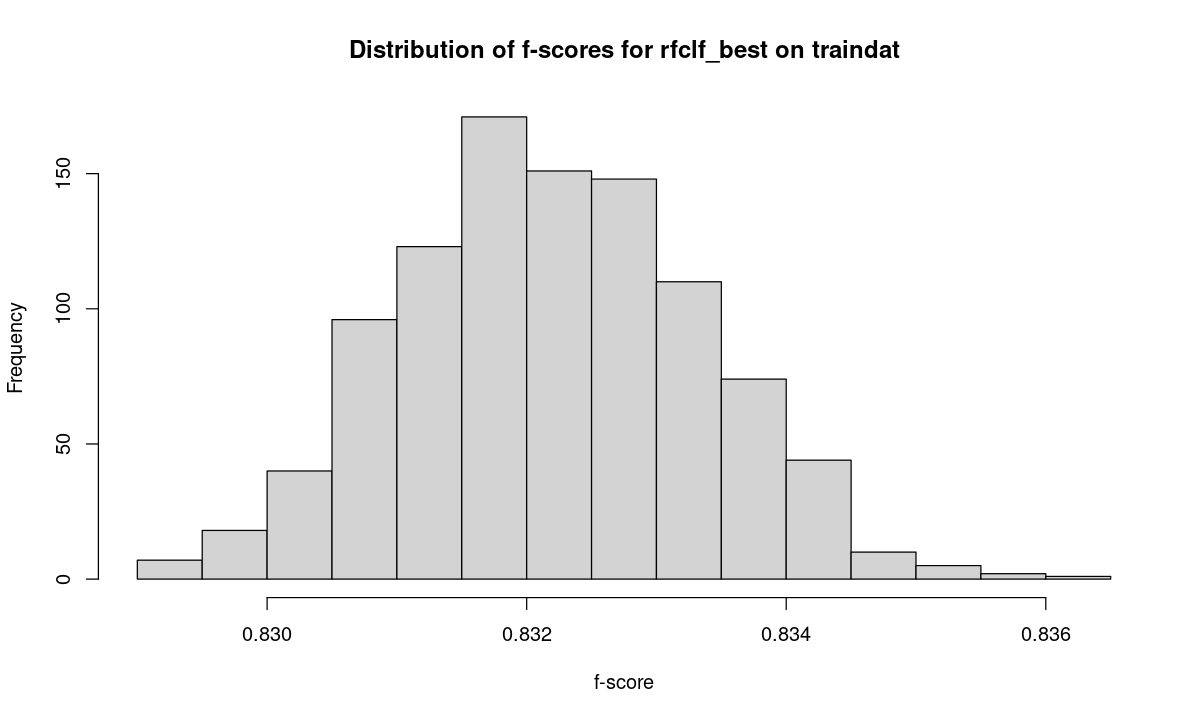

In [16]:
# Get stable scores for the best random forest model.  I will
# refer to this model as rfclf_best.  Note that 1000 seeds
# are being used.  [* 150 seeds would have been plenty *]

set.seed(1433)
seed_smp <- sample(1:9999, 1000, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

start <- Sys.time()
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(I(as.factor(Inland)) ~ ., 
                              data= rftrain, ntree=900,
                              mtry= 3, nodesize= 1)
        
    # preds <- predict(rfmod, newdata= dat, type="response")
    # ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    # mat <- as.matrix(ans[[1]])
    mat <- rfmod$confusion
    # percent_correct <- sum(diag(mat))/floor(sum(mat))
    # datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("Acc")] <- acc <- round(1-median(rfmod$err.rate[,1]), 4)
    # datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("fscore")] <- fscore <- round(get_fscore(mat), 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.76 hours

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for rfclf_best on traindat")


In [17]:
# Get summaries for rfclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.8322   
# accuracy:  0.8954   
# false negatives: 613.33   
# false positives: 449.24

# Type2: 0.8575


[1]   0.8322   0.8954 613.3300 449.2400

In [18]:
round(mean(datout$Type2), 4)
# 0.8575


[1] 0.8575

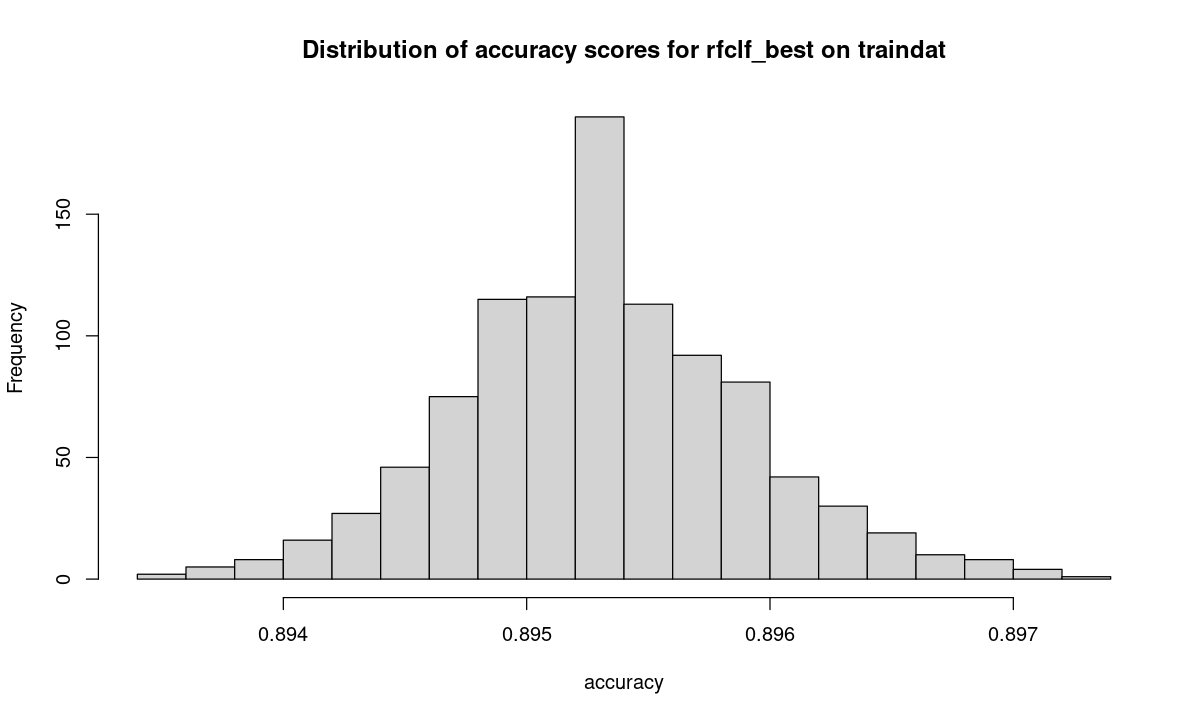

In [19]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=16, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best on traindat")


In [20]:
# Identify seeds with an accuracy score between 0.89525 
# and 0.8955.  When constructing rfclf_best, I may want
# to use a seed which has an accuracy in the center
# of the distribution of accuracy scores.  (It may be that
# rfclf_best will generalize better to the test data if
# I choose a seed for it that is at the midpoint of the
# accuracy distribution.)

rf_candidate_seeds <- datout[which((datout$Acc > 0.89525) & (datout$Acc < 0.8955)),]$seed
length(rf_candidate_seeds)
#  190
head(rf_candidate_seeds)
#  667   2700   381   4104   1493   5802


[1] 190

[1]  667 2700  381 4104 1493 5802

In [22]:
# Identify seeds with the highest accuracy scores.

rf_highAcc_seeds <- datout[which(datout$Acc > 0.897),]$seed
length(rf_highAcc_seeds)
#  5
head(rf_highAcc_seeds)
#  287   9137   9192   2191   8458


[1] 5

[1]  287 9137 9192 2191 8458

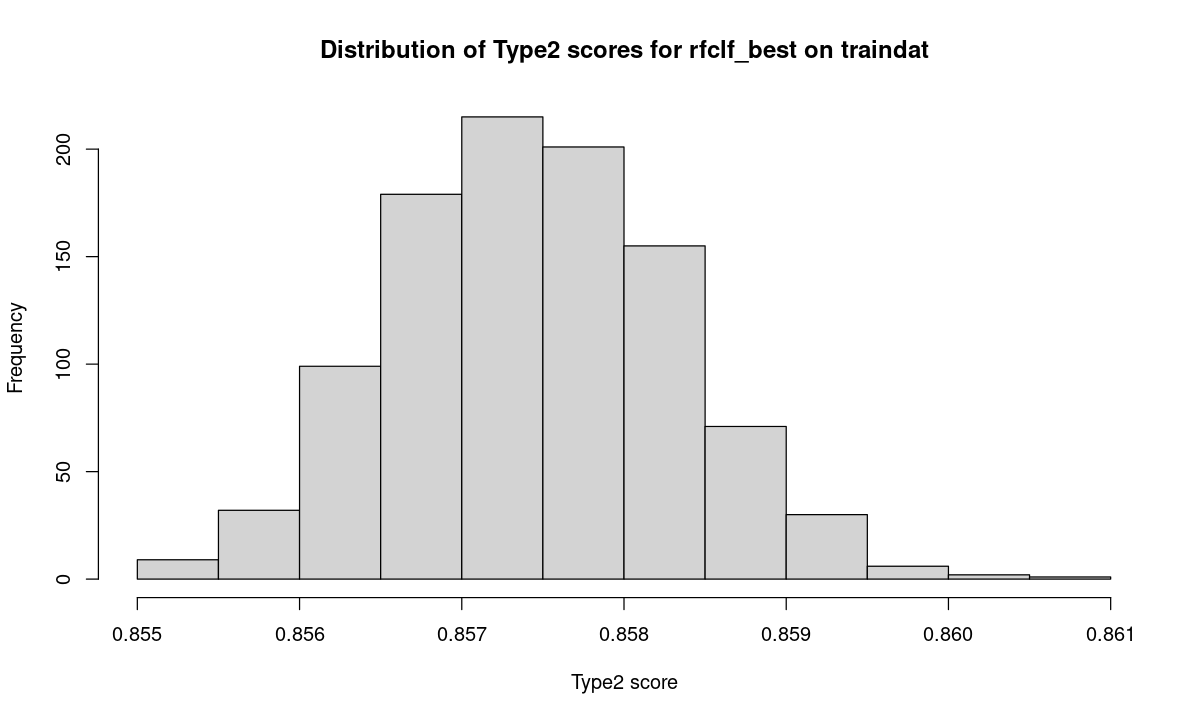

In [21]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Type2, breaks=16, xlab="Type2 score",
     main="Distribution of Type2 scores for rfclf_best on traindat")


In [15]:
# Get feature importances for rfclf_best.

set.seed(1493)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900,
                            mtry= 3, nodesize= 1, importance=TRUE))



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat[,      rfclf_columns], ntree = 900, mtry = 3, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.39%
Confusion matrix:
     0    1 class.error
0 6497  450    0.064776
1  609 2640    0.187442

In [24]:
print(round(rfclf_best$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.015 0.036                0.022           310.43
median_income      0.045 0.025                0.038           367.88
median_house_value 0.146 0.260                0.182          1666.85
HHdens_ln          0.035 0.137                0.067           947.54
rooms_per_hh       0.034 0.051                0.039           447.76
bdrms_per_room     0.033 0.039                0.035           350.40
pop_per_hh         0.017 0.018                0.018           335.81


### Get scores for rfclf_best on testdat

In [25]:
# Function for obtaining a set of scores on the testset data
# using rfclf_best as the classifier.

get_testdatScores_rf <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
    
        preds <- predict(rfclf_best, newdata= df, type="response")
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [26]:
# Get rfclf_best's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_rf(seed_vector, rftest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.12 mins


[1] "Start time: 2021-04-23 18:19:47"

Time difference of 1.12 mins

In [27]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8386,0.8995,0.8630,233,169
1953,0.8443,0.9008,0.8669,224,173
7591,0.8291,0.8915,0.8541,272,162
1038,0.8403,0.9020,0.8650,238,154
49,0.8337,0.8940,0.8578,238,186
3203,0.8373,0.8985,0.8618,234,172


In [28]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8366
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.006
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8366"

[1] "fscore StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.833   0.836   0.837   0.841   0.851 

In [29]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8979
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8979"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.887   0.895   0.898   0.898   0.900   0.907 

In [30]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8611
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0049
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8611"

[1] "Type2 StdDev: 0.0049"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.847   0.858   0.861   0.861   0.864   0.873 

In [31]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 242.34
paste0("FN StdDev: ", as.character(FN_sd))
# 11.62
""
summary(dat_result$FN)


[1] "FN mean: 242.34"

[1] "FN StdDev: 11.62"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    207     236     242     242     250     272 

In [32]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 165.95
paste0("FP StdDev: ", as.character(FP_sd))
#   9.76
""
summary(dat_result$FP)


[1] "FP mean: 165.95"

[1] "FP StdDev: 9.76"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    142     160     167     166     173     194 

## Find best gradient boosting model

### Variable selection for gradient boosting model

,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,53.22173
HHdens_ln,HHdens_ln,25.06241
rooms_per_hh,rooms_per_hh,5.16927
housing_median_age,housing_median_age,3.57757
bdrms_per_room,bdrms_per_room,3.13607
pop_per_hh,pop_per_hh,2.75024
total_rooms,total_rooms,1.84534
median_income,median_income,1.62417
population,population,1.47985


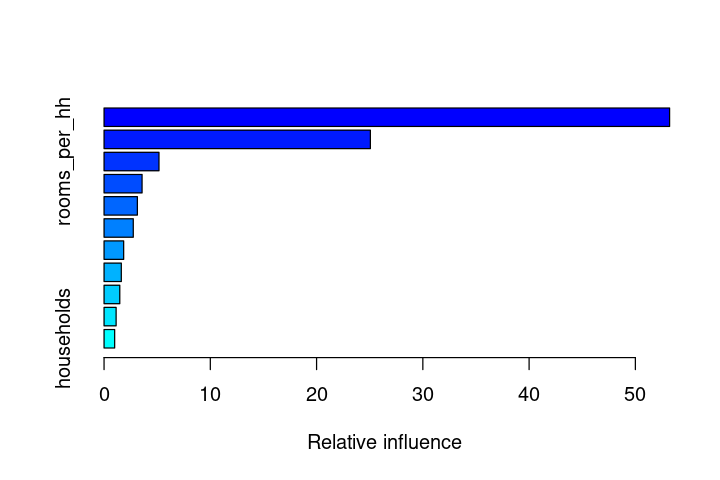

In [16]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbmod <- gbm(Inland ~ ., data= traindat, n.trees= 1000,
                  distribution= "bernoulli", shrinkage= 0.1)
summary(gbmod)


In [18]:
preds <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(traindat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, traindat[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbmod: ", as.character(ans[[2]]), sep=""))
# 0.8372

# Accuracy is 0.8994

# Type2 is 0.8621


     0    1 class.error
0 6531  416      0.0599
1  610 2639      0.1878


[1] ""

[1] "f-score for gbmod: 0.8372"


In [19]:
# Remove households and total_bedrooms.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms")))]
df <- traindat[, newcols]


,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,53.4198
HHdens_ln,HHdens_ln,25.3147
rooms_per_hh,rooms_per_hh,5.2292
housing_median_age,housing_median_age,3.6702
bdrms_per_room,bdrms_per_room,3.1768
pop_per_hh,pop_per_hh,3.0683
total_rooms,total_rooms,2.4803
population,population,1.9066
median_income,median_income,1.7341


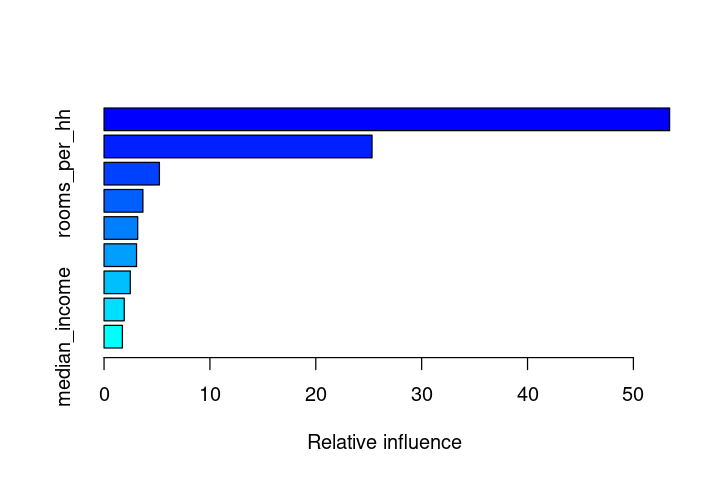

In [20]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbmod <- gbm(Inland ~ ., data= df, n.trees= 1000,
                  distribution= "bernoulli", shrinkage= 0.1)
summary(gbmod)


In [21]:
preds <- suppressMessages(predict(gbmod, newdata= df, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(df)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, df[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbmod: ", as.character(ans[[2]]), sep=""))
# 0.8365

# Accuracy is 0.8989

# Type2 is 0.8615


     0    1 class.error
0 6524  423      0.0609
1  609 2640      0.1874


[1] ""

[1] "f-score for gbmod: 0.8365"


In [22]:
# See what results are when we remove population.  We already
# have pop_per_hh.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms",
                                        "population")))]
df <- traindat[, newcols]


,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,53.7036
HHdens_ln,HHdens_ln,25.5192
rooms_per_hh,rooms_per_hh,5.3179
housing_median_age,housing_median_age,3.7408
total_rooms,total_rooms,3.5693
bdrms_per_room,bdrms_per_room,3.2124
pop_per_hh,pop_per_hh,3.1650
median_income,median_income,1.7718


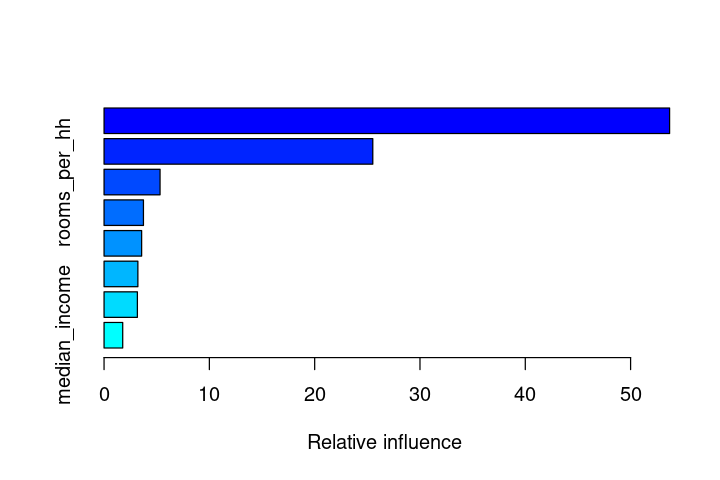

In [23]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbmod <- gbm(Inland ~ ., data= df, n.trees= 1000,
                  distribution= "bernoulli", shrinkage= 0.1)
summary(gbmod)


In [24]:
preds <- suppressMessages(predict(gbmod, newdata= df, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(df)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, df[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbmod: ", as.character(ans[[2]]), sep=""))
# 0.8346

# Accuracy is 0.8974

# Type2 is 0.8597


     0    1 class.error
0 6511  436      0.0628
1  610 2639      0.1878


[1] ""

[1] "f-score for gbmod: 0.8346"


In [25]:
# See what results are when we remove median_income 
# instead of population.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("households","total_bedrooms",
                                        "median_income")))]
df <- traindat[, newcols]


,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,54.3413
HHdens_ln,HHdens_ln,25.7256
rooms_per_hh,rooms_per_hh,5.3308
housing_median_age,housing_median_age,3.7384
pop_per_hh,pop_per_hh,3.2143
bdrms_per_room,bdrms_per_room,2.8958
total_rooms,total_rooms,2.6660
population,population,2.0879


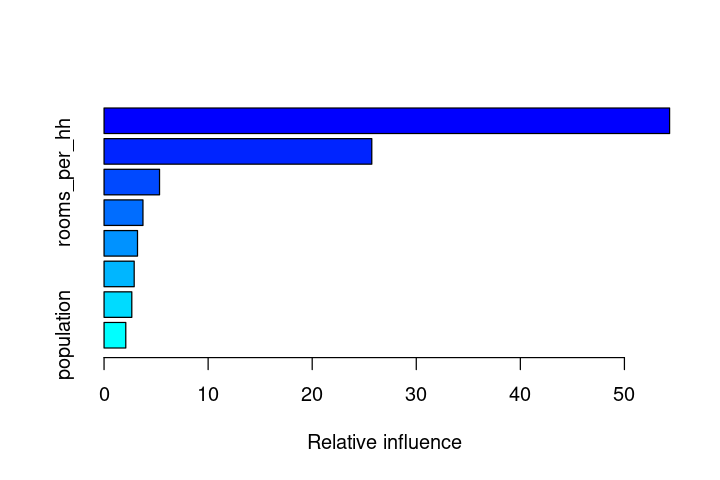

In [26]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbmod <- gbm(Inland ~ ., data= df, n.trees= 1000,
                  distribution= "bernoulli", shrinkage= 0.1)
summary(gbmod)


In [27]:
preds <- suppressMessages(predict(gbmod, newdata= df, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(df)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, df[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbmod: ", as.character(ans[[2]]), sep=""))
# 0.8355

# Accuracy is 0.8984

# Type2 is 0.8607


     0    1 class.error
0 6530  417      0.0600
1  619 2630      0.1905


[1] ""

[1] "f-score for gbmod: 0.8355"


In [17]:
# Identify the columns we will use for our gradient boosting
# model.  There are 8 predictors.

gbclf_columns <- c('Inland','housing_median_age','population',
                   'median_house_value','HHdens_ln','rooms_per_hh',
                   'bdrms_per_room','pop_per_hh','total_rooms')


In [34]:
# Restrict variables in traindat and testdat for gradient
# boosting modeling.

gbtrain <- traindat[, gbclf_columns]
gbtest <- testdat[, gbclf_columns]


### Tune the gradient boosting model

In [35]:
# This function is called from get_cvScore_gb.

get_Type2_gb <- function(traindat, valdat, ntrees, shrinkage) {
        
    gbmod <- gbm(Inland ~ ., data= traindat, n.trees=ntrees,
                  distribution= "bernoulli", shrinkage=shrinkage)
        
    preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    names(preds) <- rownames(valdat)
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    preds <- as.factor(preds)
    ans <- get_confusion(preds, valdat[, "Inland", drop=FALSE])

    # Type2 score is average of accuracy and f-score.
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(result)
}


In [31]:
# Function to obtain a cross-validation score, averaging the
# Type2 scores of the folds.  This function is called from
# avg_seedScores_gb.

get_cvScore_gb <- function(seed, dat, ntrees, shrinkage,
                           folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_gb, train_list, test_list,
                       MoreArgs= list(ntrees= ntrees, shrinkage=shrinkage),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [32]:
# Since the seed value can have a big effect on the results,
# I take the average over a number of seeds.  This ftn is
# called from gridSearch03.

avg_seedScores_gb <- function(seed_vector, traindat, n_trees,  
                              shrinkage, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_gb(seed, traindat, n_trees,
                                  shrinkage, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [33]:
# This grid search is specific to finding the best random forest
# classifier for traindat.

gridSearch03 <- function(seed_vector, traindat, ntree_vector, 
                         shrinkagev, folds=5) {
    
    tree_len <- length(ntree_vector)
    shrink_len <- length(shrinkagev)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * shrink_len)
    dim(datout) <- c((tree_len * shrink_len ), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        for(j in 1:shrink_len) {
            shrinkage <- shrinkagev[j]
            index <- index + 1
            param_string <- paste(as.character(n_trees), 
                                  as.character(shrinkage), sep= "--")
                datout$params[index] <- param_string
                datout$Type2[index] <- avg_seedScores_gb(seed_vector, traindat, n_trees, 
                                                         folds=folds, shrinkage=shrinkage)
        }
    }
    return(datout)
}


In [35]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 21 seeds.  For each
# seed, an average is taken over 5 folds.

set.seed(7543)
seed_smp <- sample(1:9999, 21, replace=FALSE)
tree_vector <- c(750, 900, 1000, 1200)
shrinkage_v <- c(0.05, 0.08, 0.1, 0.15, 0.2)


start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch03(seed_smp, gbtrain, tree_vector, shrinkage_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 11 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '750--0.1'

(best_rf_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.8477


[1] "Start time: 2021-04-23 09:10:16"

Time difference of 11.05 mins

[1] "750--0.1"

[1] 0.84767

In [36]:
# Refine the search.

set.seed(7541)
seed_smp <- sample(1:9999, 21, replace=FALSE)
tree_vector <- c(400, 600, 750)
shrinkage_v <- c(0.08, 0.1, 0.12)


start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch03(seed_smp, gbtrain, tree_vector, shrinkage_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '750--0.1'

(best_rf_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.8476


[1] "Start time: 2021-04-23 09:24:16"

Time difference of 3 mins

[1] "750--0.1"

[1] 0.84761

In [37]:
ans


params,Type2
<chr>,<dbl>
400--0.08,0.84525
400--0.1,0.84582
400--0.12,0.84678
600--0.08,0.84696
600--0.1,0.84738
600--0.12,0.84715
750--0.08,0.84723
750--0.1,0.84761
750--0.12,0.84666


### Get scores for gbclf_best on traindat

Time difference of 5.19 mins

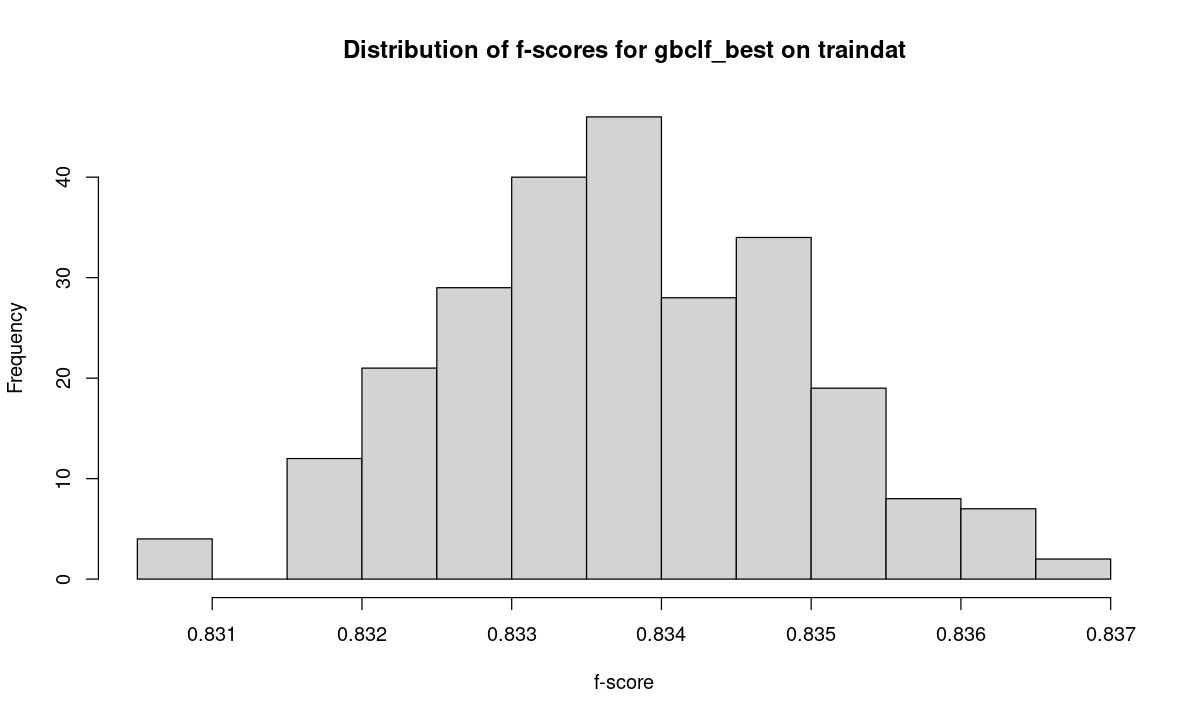

In [36]:
# Get stable scores for the best gradient boosting model. 
# I will refer to this model as gbclf_best.  Note that 
# 250 seeds are being used.

set.seed(1433)
seed_smp <- sample(1:9999, 250, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

start <- Sys.time()
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    gbmod <- gbm(Inland ~ ., data= gbtrain, n.trees=750,
                  distribution= "bernoulli", shrinkage=0.1)
        
    preds <- suppressMessages(predict(gbmod, newdata= gbtrain, type="response"))
    names(preds) <- rownames(gbtrain)
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    preds <- as.factor(preds)
    ans <- get_confusion(preds, gbtrain[, "Inland", drop=FALSE])
        
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- acc <- round(percent_correct, 4)
    datout[i, c("fscore")] <- fscore <- round(ans[[2]], 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.19 mins

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for gbclf_best on traindat")


In [37]:
# Get summaries for gbclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.8338   
# accuracy:  0.8974   
# false negatives: 625.56   
# false positives: 420.32

# Type2: 0.8592


[1]   0.8338   0.8974 625.5600 420.3200

In [38]:
round(mean(datout$Type2), 4)
# 0.8592


[1] 0.8592

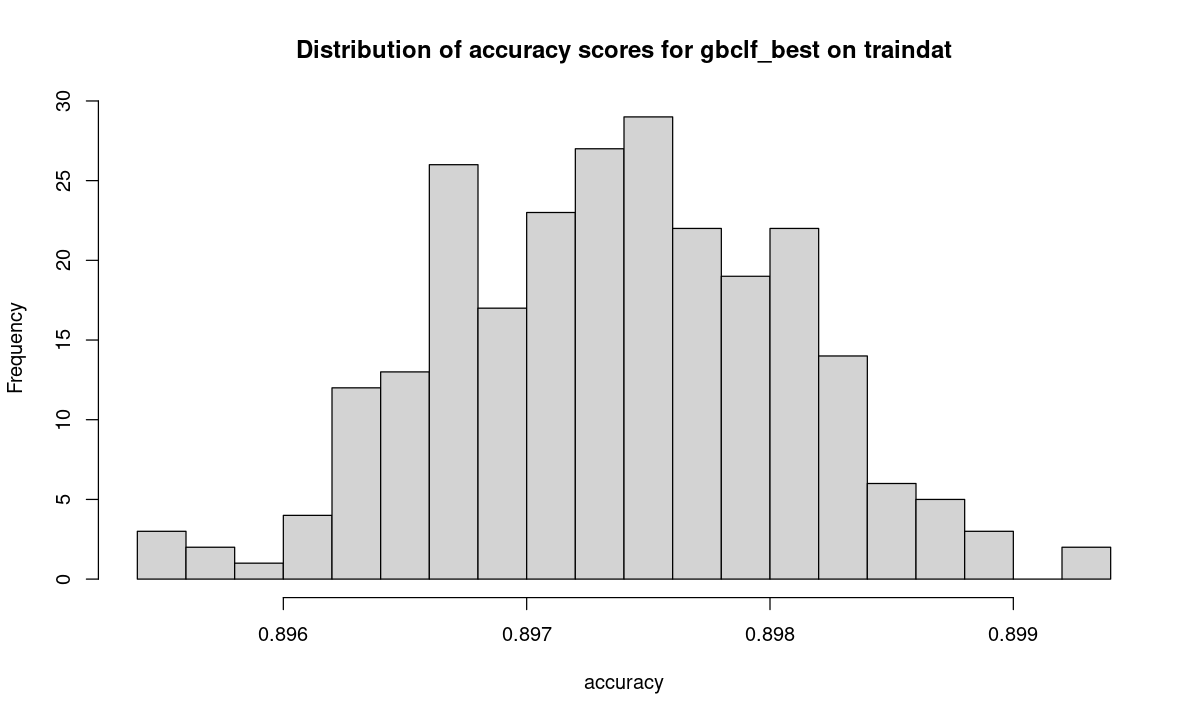

In [39]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=16, xlab="accuracy",
     main="Distribution of accuracy scores for gbclf_best on traindat")


In [40]:
# Identify seeds with an accuracy score between 0.8974 
# and 0.8976.  When constructing gbclf_best, I may want
# to use a seed which has an accuracy in the center
# of the distribution of accuracy scores.  (It may be that
# gbclf_best will generalize better to the test data if
# I choose a seed for it that is at the midpoint of the
# accuracy distribution.)

gb_candidate_seeds <- datout[which((datout$Acc > 0.8974) & (datout$Acc < 0.8976)),]$seed
length(gb_candidate_seeds)
#  16
head(gb_candidate_seeds)
#  4621   9214   5711   7584   6932   2254 


[1] 16

[1] 4621 9214 5711 7584 6932 2254

In [42]:
# Identify seeds with the highest accuracy scores.

gb_highAcc_seeds <- datout[which(datout$Acc > 0.8985),]$seed
length(gb_highAcc_seeds)
#  12
head(gb_highAcc_seeds)
#  6937   5021   64   2650   3393   3057


[1] 12

[1] 6937 5021   64 2650 3393 3057

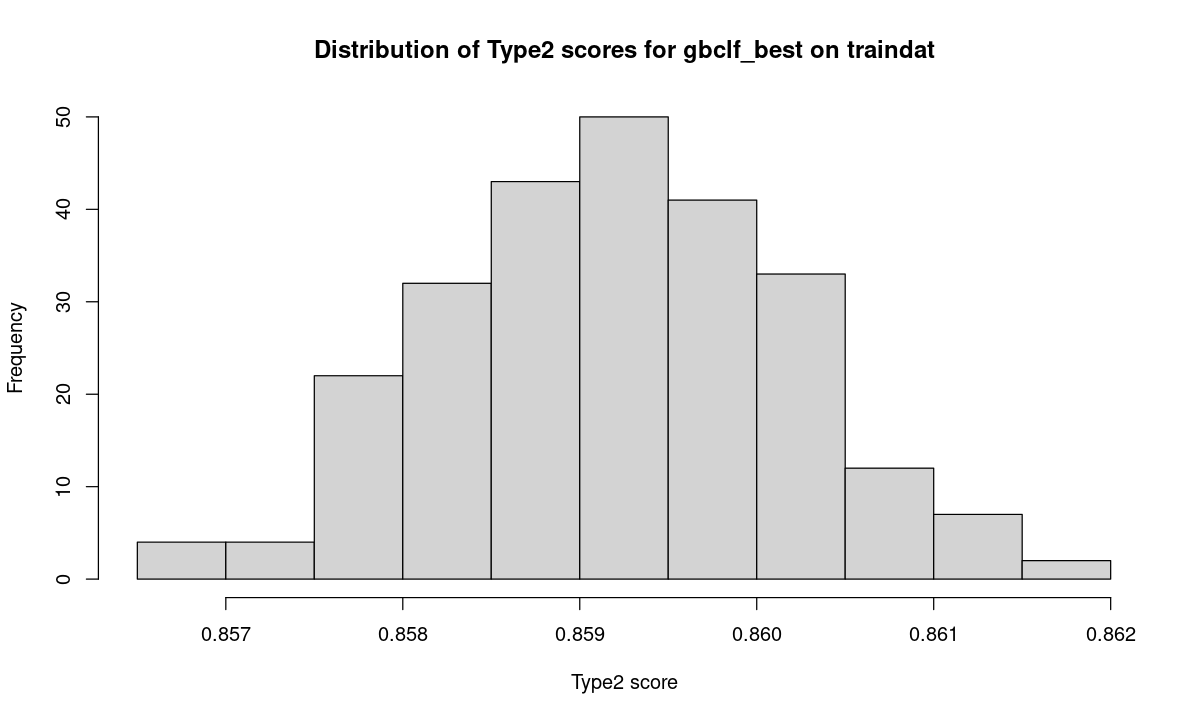

In [43]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Type2, breaks=16, xlab="Type2 score",
     main="Distribution of Type2 scores for gbclf_best on traindat")


,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,55.9842
HHdens_ln,HHdens_ln,25.8345
rooms_per_hh,rooms_per_hh,5.7162
housing_median_age,housing_median_age,3.3490
pop_per_hh,pop_per_hh,2.8637
total_rooms,total_rooms,2.2532
bdrms_per_room,bdrms_per_room,2.1195
population,population,1.8798


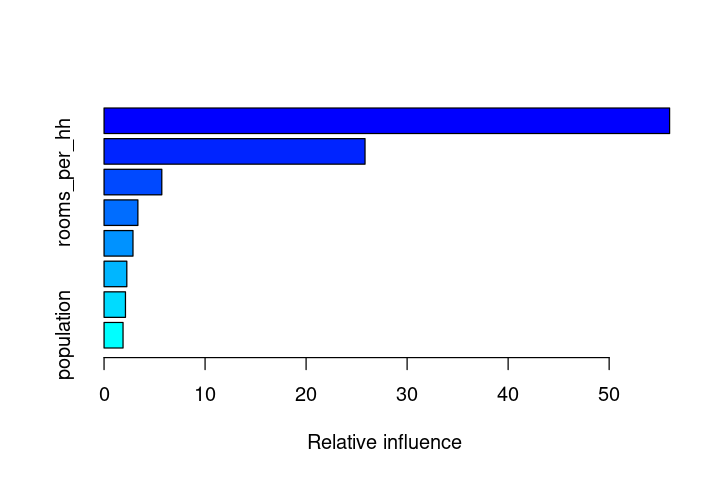

In [44]:
# Get feature importances for gbclf_best.

set.seed(5711)
gbclf_best <- gbm(Inland ~ ., data= gbtrain, n.trees=750,
                  distribution= "bernoulli", shrinkage=0.1)

options(repr.plot.width= 6, repr.plot.height= 4)
summary(gbclf_best)


### Get scores for gbclf_best on testdat

In [45]:
# Function for obtaining a set of scores on the testset data
# using gbclf_best as the classifier.

get_testdatScores_gb <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        preds <- suppressMessages(predict(gbclf_best, newdata= df, type="response"))
        names(preds) <- rownames(df)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [46]:
# Get gbclf_best's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_gb(seed_vector, gbtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 9.28 secs


[1] "Start time: 2021-04-23 18:42:11"

Time difference of 9.28 secs

In [47]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8274,0.8925,0.8534,246,184
1953,0.8268,0.8902,0.8522,252,187
7591,0.8116,0.8810,0.8394,300,176
1038,0.8216,0.8908,0.8493,263,174
49,0.8251,0.8890,0.8507,254,190
3203,0.8216,0.8895,0.8488,261,181


In [48]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8204
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0065
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8204"

[1] "fscore StdDev: 0.0065"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.802   0.816   0.821   0.820   0.824   0.837 

In [49]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8882
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0039
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8882"

[1] "accuracy StdDev: 0.0039"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.877   0.886   0.888   0.888   0.891   0.899 

In [50]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8475
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0054
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8475"

[1] "Type2 StdDev: 0.0054"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.832   0.844   0.848   0.848   0.851   0.862 

In [51]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 265.96
paste0("FN StdDev: ", as.character(FN_sd))
# 11.92
""
summary(dat_result$FN)


[1] "FN mean: 265.96"

[1] "FN StdDev: 11.92"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    233     257     266     266     273     302 

In [52]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 181.21
paste0("FP StdDev: ", as.character(FP_sd))
# 10.49
""
summary(dat_result$FP)


[1] "FP mean: 181.21"

[1] "FP StdDev: 10.49"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    149     174     182     181     188     209 

In [ ]:
### COMMENT:

# rfclf_best looks to be a slightly better model than 
# gbclf_best.


## Find best logistic regression model

### Variable selection

In [14]:
f01 <- glm(Inland ~ ., data=traindat, family=binomial())
summary(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = traindat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.148  -0.499  -0.163   0.405   4.859  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         6.07e+00   7.71e-01    7.87  3.6e-15
housing_median_age -2.78e-02   2.92e-03   -9.54  < 2e-16
total_rooms         1.53e-04   7.64e-05    2.01  0.04447
total_bedrooms     -2.55e-03   6.73e-04   -3.78  0.00016
population         -2.33e-04   1.29e-04   -1.80  0.07125
households          2.72e-03   8.19e-04    3.33  0.00088
median_income      -2.39e-01   4.31e-02   -5.54  2.9e-08
median_house_value -2.32e-05   7.05e-07  -32.98  < 2e-16
HHdens_ln          -4.05e-01   2.47e-02  -16.41  < 2e-16
rooms_per_hh        7.67e-01   7.67e-02   10.00  < 2e-16
bdrms_per_room     -8.23e+00   1.81e+00   -4.56  5.2e-06
pop_per_hh         -2.86e-01   6.33e-02   -4.52  6.2e-06

(Dispersion parameter for binomial family taken to be 1)

    Null d

In [15]:
# Remove population as a predictor.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("population")))]
df <- traindat[, newcols]


In [16]:
f01 <- glm(Inland ~ ., data=df, family=binomial())
summary(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.161  -0.501  -0.163   0.405   4.856  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         6.37e+00   7.54e-01    8.45  < 2e-16
housing_median_age -2.78e-02   2.92e-03   -9.52  < 2e-16
total_rooms         1.20e-04   7.39e-05    1.63  0.10321
total_bedrooms     -2.26e-03   6.56e-04   -3.44  0.00059
households          1.93e-03   6.94e-04    2.78  0.00537
median_income      -2.38e-01   4.31e-02   -5.53  3.3e-08
median_house_value -2.32e-05   7.04e-07  -32.94  < 2e-16
HHdens_ln          -4.04e-01   2.47e-02  -16.36  < 2e-16
rooms_per_hh        7.65e-01   7.68e-02    9.97  < 2e-16
bdrms_per_room     -8.50e+00   1.80e+00   -4.71  2.4e-06
pop_per_hh         -3.75e-01   4.15e-02   -9.02  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degrees of freedom
Residual devianc

In [17]:
# Remove total_rooms as a predictor.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("population","total_rooms")))]
df <- traindat[, newcols]


In [18]:
f01 <- glm(Inland ~ ., data=df, family=binomial())
summary(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.172  -0.500  -0.162   0.408   4.835  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         6.31e+00   7.53e-01    8.39  < 2e-16
housing_median_age -2.75e-02   2.91e-03   -9.43  < 2e-16
total_bedrooms     -1.88e-03   6.11e-04   -3.07  0.00212
households          2.20e-03   6.67e-04    3.31  0.00094
median_income      -2.33e-01   4.30e-02   -5.43  5.7e-08
median_house_value -2.32e-05   7.04e-07  -33.00  < 2e-16
HHdens_ln          -4.07e-01   2.47e-02  -16.46  < 2e-16
rooms_per_hh        7.95e-01   7.42e-02   10.72  < 2e-16
bdrms_per_room     -9.17e+00   1.77e+00   -5.19  2.1e-07
pop_per_hh         -3.68e-01   4.13e-02   -8.91  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degrees of freedom
Residual deviance:  6731.1  on 10186  degrees of freedom
AIC: 6751

Numbe

In [19]:
# Remove total_bedrooms.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("population","total_rooms",
                                        "total_bedrooms")))]
df <- traindat[, newcols]


In [20]:
f01 <- glm(Inland ~ ., data=df, family=binomial())
summary(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.237  -0.503  -0.163   0.409   4.832  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         7.56e+00   6.37e-01   11.86  < 2e-16
housing_median_age -2.74e-02   2.91e-03   -9.41  < 2e-16
households          1.77e-04   8.26e-05    2.14    0.032
median_income      -2.16e-01   4.27e-02   -5.06  4.3e-07
median_house_value -2.31e-05   7.04e-07  -32.87  < 2e-16
HHdens_ln          -4.07e-01   2.47e-02  -16.48  < 2e-16
rooms_per_hh        6.57e-01   5.80e-02   11.33  < 2e-16
bdrms_per_room     -1.21e+01   1.50e+00   -8.04  9.1e-16
pop_per_hh         -3.57e-01   4.09e-02   -8.74  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degrees of freedom
Residual deviance:  6739.5  on 10187  degrees of freedom
AIC: 6758

Number of Fisher Scoring iterations: 6


In [21]:
# Remove households.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("population","total_rooms",
                                        "total_bedrooms","households")))]
df <- traindat[, newcols]


In [23]:
f01 <- glm(Inland ~ ., data=df, family=binomial())
summary(f01)
get_RsqrdDev(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.235  -0.505  -0.163   0.407   4.826  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         7.68e+00   6.33e-01   12.13  < 2e-16
housing_median_age -2.98e-02   2.69e-03  -11.06  < 2e-16
median_income      -2.19e-01   4.26e-02   -5.15  2.6e-07
median_house_value -2.31e-05   7.02e-07  -32.86  < 2e-16
HHdens_ln          -4.00e-01   2.44e-02  -16.36  < 2e-16
rooms_per_hh        6.55e-01   5.79e-02   11.32  < 2e-16
bdrms_per_room     -1.20e+01   1.50e+00   -8.03  9.4e-16
pop_per_hh         -3.66e-01   4.07e-02   -8.98  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degrees of freedom
Residual deviance:  6744.1  on 10188  degrees of freedom
AIC: 6760

Number of Fisher Scoring iterations: 6


[1] 0.6244

In [25]:
# Add power transformation.

f01 <- glm(Inland ~ housing_median_age + median_income +
           I(log(median_house_value)) +
           HHdens_ln +
           rooms_per_hh +
           bdrms_per_room +
           pop_per_hh, 
           data=df, family=binomial())
           
summary(f01)
get_RsqrdDev(f01)



Call:
glm(formula = Inland ~ housing_median_age + median_income + I(log(median_house_value)) + 
    HHdens_ln + rooms_per_hh + bdrms_per_room + pop_per_hh, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.355  -0.474  -0.176   0.323   3.674  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)
(Intercept)                 54.64413    1.39729   39.11  < 2e-16
housing_median_age          -0.03526    0.00278  -12.69  < 2e-16
median_income               -0.15859    0.04024   -3.94  8.1e-05
I(log(median_house_value))  -4.12299    0.11195  -36.83  < 2e-16
HHdens_ln                   -0.36888    0.02438  -15.13  < 2e-16
rooms_per_hh                 0.50661    0.04965   10.20  < 2e-16
bdrms_per_room             -16.69153    1.44595  -11.54  < 2e-16
pop_per_hh                  -0.42148    0.04425   -9.52  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degre

[1] 0.6526

In [37]:
# Tweak power transformation.

f02 <- glm(Inland ~ housing_median_age + median_income +
           I(median_house_value^-0.07) +
           HHdens_ln +
           rooms_per_hh +
           bdrms_per_room +
           pop_per_hh, 
           data=df, family=binomial())
           
summary(f02)
get_RsqrdDev(f02)



Call:
glm(formula = Inland ~ housing_median_age + median_income + I(median_house_value^-0.07) + 
    HHdens_ln + rooms_per_hh + bdrms_per_room + pop_per_hh, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.372  -0.473  -0.179   0.319   3.621  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)
(Intercept)                 -53.06331    1.75378  -30.26  < 2e-16
housing_median_age           -0.03582    0.00278  -12.89  < 2e-16
median_income                -0.16913    0.03980   -4.25  2.1e-05
I(median_house_value^-0.07) 135.29657    3.67098   36.86  < 2e-16
HHdens_ln                    -0.36586    0.02432  -15.04  < 2e-16
rooms_per_hh                  0.49415    0.04906   10.07  < 2e-16
bdrms_per_room              -17.18793    1.44128  -11.93  < 2e-16
pop_per_hh                   -0.42245    0.04443   -9.51  < 2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10

[1] 0.653

In [62]:
# Remove median_income since it is highly correlated 
# with median_house_value.

f03 <- glm(Inland ~ housing_median_age + 
           I(median_house_value^-0.07) +
           HHdens_ln +
           rooms_per_hh +
           bdrms_per_room +
           pop_per_hh, 
           data=df, family=binomial())
           
summary(f03)
get_RsqrdDev(f03)



Call:
glm(formula = Inland ~ housing_median_age + I(median_house_value^-0.07) + 
    HHdens_ln + rooms_per_hh + bdrms_per_room + pop_per_hh, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.561  -0.476  -0.183   0.313   3.668  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)
(Intercept)                 -57.59162    1.42342  -40.46   <2e-16
housing_median_age           -0.03339    0.00271  -12.31   <2e-16
I(median_house_value^-0.07) 143.96126    3.13262   45.96   <2e-16
HHdens_ln                    -0.38429    0.02400  -16.01   <2e-16
rooms_per_hh                  0.45672    0.04675    9.77   <2e-16
bdrms_per_room              -14.83195    1.30166  -11.39   <2e-16
pop_per_hh                   -0.44305    0.04421  -10.02   <2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 12762.4  on 10195  degrees of freedom
Residual deviance:  6379.5  on 10189  degrees of freedom
A

[1] 0.6517

### f03 model diagnostics

In [59]:
# Check for dispersion <> 1.

# We want the following value to NOT be considerably larger
# than 1.  If it is, then we have to use family= quasibinomial
# in our modeling. (See p.311 of Kabacoff's "R in Action".)

phi <- deviance(f03)/df.residual(f03)
print(round(phi, 3))


[1] 0.626


In [ ]:
### COMMENT:

# The f03 model has dispersion < 1.  This under-
# dispersion does not affect the parameter estimates.  
# But it means that the standard errors for our model
# coefficients, as seen in the above summary, 
# are larger than what they should be.


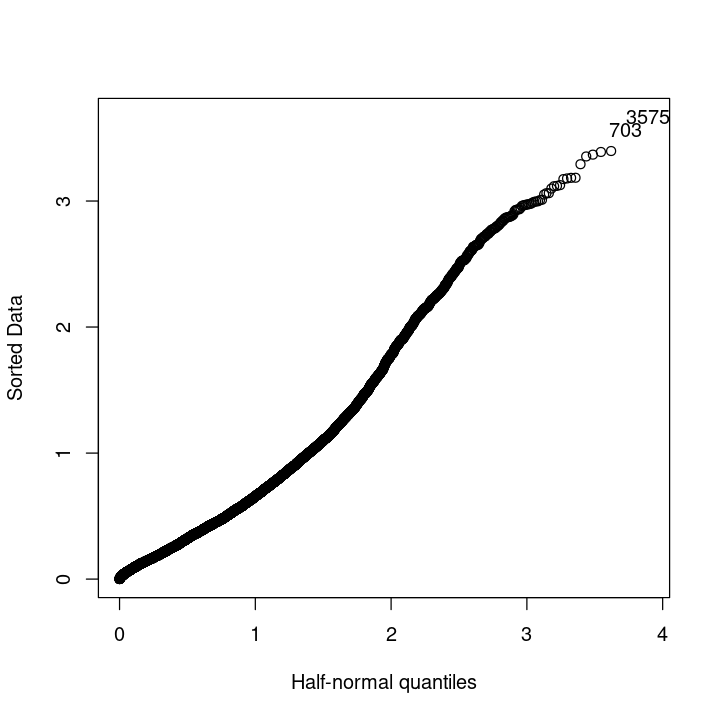

In [63]:
# Plot the residuals.  Julian Faraway's half-normal plot can
# be used to check for outliers.  See p.46 of Faraway's 
# "Extending the Linear Model with R".  The residuals plotted
# here are the deviance residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

# Function halfnorm is from package faraway.
halfnorm(residuals(f03))


In [ ]:
### COMMENT:

# The diagnostics look ok for our purposes.


### Get scores for f03 on testdat

In [15]:
f03_columns <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("population","total_rooms",
                                        "total_bedrooms","households",
                                        "median_income")))]


In [64]:
f03train <- traindat[, f03_columns]
f03test <- testdat[, f03_columns]


In [65]:
# Function for obtaining a set of scores on the testset data
# using f03 as the classifier.

get_testdatScores_f03 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(f03, newdata= df)
        names(preds) <- rownames(df)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [66]:
# Get f03's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_f03(seed_vector, f03test)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5 secs


Time difference of 4.99 secs

In [67]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7916,0.8805,0.8272,369,109
1953,0.7779,0.8722,0.8156,405,106
7591,0.7639,0.8628,0.8035,437,112
1038,0.7771,0.8745,0.8161,394,108
49,0.7831,0.8732,0.8191,386,121
3203,0.7759,0.8728,0.8147,398,111


In [68]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7765
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0076
""
summary(dat_result$fscore)


[1] "fscore mean: 0.7765"

[1] "fscore StdDev: 0.0076"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.760   0.771   0.776   0.776   0.781   0.799 

In [69]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8725
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0042
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8725"

[1] "accuracy StdDev: 0.0042"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.863   0.870   0.873   0.872   0.875   0.883 

In [70]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8149
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.006
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8149"

[1] "Type2 StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.801   0.811   0.815   0.815   0.819   0.832 

In [71]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 401.55
paste0("FN StdDev: ", as.character(FN_sd))
# 14.29
""
summary(dat_result$FN)


[1] "FN mean: 401.55"

[1] "FN StdDev: 14.29"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    369     393     401     402     411     437 

In [72]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 108.58
paste0("FP StdDev: ", as.character(FP_sd))
# 8.36
""
summary(dat_result$FP)


[1] "FP mean: 108.58"

[1] "FP StdDev: 8.36"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     89     102     109     109     114     134 

In [ ]:
### COMMENT:

# f03 does a great job avoiding false positives.
# But it is very high on the false negatives.  It's
# mean accuracy is more than 2.5 percentage points lower
# than the mean accuracy for rfclf_best.  On average,
# f03 mis-classifies 200 more districts (of the 10K) than  
# does rfclf_best.


### Add median_income back to the model; get scores on testset

In [73]:
f04 <- glm(Inland ~ housing_median_age + median_income +
           I(median_house_value^-0.07) +
           HHdens_ln +
           rooms_per_hh +
           bdrms_per_room +
           pop_per_hh, 
           data=traindat, family=binomial())
get_RsqrdDev(f04)


[1] 0.653

In [74]:
# Function for obtaining a set of scores on the testset data
# using f03 as the classifier.

get_testdatScores_f04 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(f04, newdata= df)
        names(preds) <- rownames(df)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [75]:
# Get f04's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_f04(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5 secs


Time difference of 4.98 secs

In [76]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7888,0.8792,0.8250,375,108
1953,0.7732,0.8698,0.8118,412,109
7591,0.7657,0.8635,0.8048,433,113
1038,0.7767,0.8742,0.8157,394,109
49,0.7794,0.8715,0.8162,393,121
3203,0.7717,0.8708,0.8113,405,112


In [77]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7748
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0077
""
summary(dat_result$fscore)


[1] "fscore mean: 0.7748"

[1] "fscore StdDev: 0.0077"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.757   0.770   0.775   0.775   0.780   0.799 

In [78]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8717
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0043
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8717"

[1] "accuracy StdDev: 0.0043"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.862   0.869   0.872   0.872   0.875   0.883 

In [ ]:
### COMMENT:

# The scores on the testset are slightly worse when 
# we include median_income in the model  Thus, I will
# stick with the f03 model.


In [80]:
rm(f04)


In [87]:
colnames(f03train)


[1] "Inland"             "housing_median_age" "median_house_value"
[4] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[7] "pop_per_hh"

## Find best SVM

In [84]:
colnames(rftrain)


[1] "Inland"             "housing_median_age" "median_income"     
[4] "median_house_value" "HHdens_ln"          "rooms_per_hh"      
[7] "bdrms_per_room"     "pop_per_hh"

In [86]:
gbclf_columns


[1] "Inland"             "housing_median_age" "population"        
[4] "median_house_value" "HHdens_ln"          "rooms_per_hh"      
[7] "bdrms_per_room"     "pop_per_hh"         "total_rooms"

In [16]:
svm02_columns <- f03_columns


In [88]:
# We need a dataframe for the svm modeling.  Use only
# the f03 predictors; this will help with computation time.

svmtrain <- traindat[, colnames(f03train)]
svmtrain$median_house_value <- log(svmtrain$median_house_value)

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(as.numeric(svmtrain$Inland), svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [89]:
# Test out a support vector machine.  Try kernel =
# radial basis function.

svm01 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 1.0, cost= 700, scale=FALSE)

pred <- fitted(svm01)
(ans <- table(pred, as.factor(svmtrain$Inland)))
get_fscore(as.matrix(ans))


    
pred    0    1
   0 6904  120
   1   43 3129

[1] 0.9746

In [92]:
# Prepare the testset data.

svmtest <- testdat[, colnames(f03train)]
svmtest$median_house_value <- log(svmtest$median_house_value)

svmtest_scaled <- scale(svmtest[, -1], center=svm_centers,
                        scale=svm_scales)
svmtest_scaled <- as.data.frame(cbind(as.numeric(svmtest$Inland),svmtest_scaled), 
                                row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


In [93]:
# Function to compute a Type2 score for an svm cv-fold.

get_Type2_svm <- function(traindat, valdat, gamma, cost) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(as.numeric(traindat$Inland), train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Inland)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    valdat_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    valdat_scaled <- as.data.frame(cbind(as.numeric(valdat$Inland),valdat_scaled), 
                                   row.names=rownames(valdat))
    colnames(valdat_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= valdat_scaled)
    ans <- table(preds, as.factor(valdat$Inland))

    mat <- as.matrix(ans)
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(result)
}


In [94]:
# This grid search searches for the best parameters for svm
# modeling of the data.  It takes a vector of seeds.

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the Type2 score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                names(row_list) <- as.character(1:folds)
                startpt <- 1
                for(k in 1:folds) {
                    endpt <- startpt + segmentsv[k] - 1
                    stopifnot(endpt <= nrow(dat))
                    row_list[[k]] <- rownames(dat)[startpt:endpt]
                    startpt <- endpt + 1
                }
            
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_Type2_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the Type2
                # scores, the average taken over the folds.
                seed_scores[h] <- round(mean(scores), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Type2[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [95]:
# Run grid search to get better parameters for the 
# svm classifier.

set.seed(7543)
seed_vector <- sample(1:9999, 1, replace=FALSE)

gamma_v <- seq(0.1, 1.0, by=0.1)
cost_v <- seq(100, 700, by=100)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, svmtrain, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 13.81 mins (with 1 seed)

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.1--100'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.8509


[1] "Start time: 2021-04-24 15:03:18"

Time difference of 13.81 mins

[1] "0.1--100"

[1] 0.8509

In [97]:
# Refine the grid search.

set.seed(7541)
seed_vector <- sample(1:9999, 5, replace=FALSE)

gamma_v <- seq(0.04, 0.1, by=0.02)
cost_v <- seq(80, 120, by=20)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, svmtrain, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 mins (with 5 seeds)

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.06--80'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.8523


[1] "Start time: 2021-04-24 15:24:11"

Time difference of 2.96 mins

[1] "0.06--80"

[1] 0.85229

In [ ]:
#&* Bookmark

In [98]:
# Construct an svm with the identified parameters.

# We need to get probability estimates from the output.
## Note the use of svm_scaled (which is just svmtrain, scaled)
svm02 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
               gamma=0.06, cost=80, scale=FALSE, probability=TRUE)

pred <- fitted(svm02)
(ans <- table(pred, as.factor(svm_scaled$Inland)))
print(paste("f-score for 'best' svm classifier, trainset: ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# 0.8368

# Accuracy is 0.9004

# Type2 is 0.8622


    
pred    0    1
   0 6575  644
   1  372 2605

[1] "f-score for 'best' svm classifier, trainset: 0.8368"


### Get scores for svm02 on testdat

In [103]:
# Function for obtaining a set of scores on the testset data
# using svm02 as the classifier.

get_testdatScores_svm02 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        df_scaled <- scale(df[, -1], center=svm_centers,
                        scale=svm_scales)
        df_scaled <- as.data.frame(cbind(as.numeric(df$Inland),df_scaled), 
                                   row.names=rownames(df))
        colnames(df_scaled) <- colnames(df)
        
        preds <- predict(svm02, newdata=df_scaled, scale=FALSE, probability=TRUE)
        preds_transf <- as.numeric(attr(preds, "probabilities")[, 2])
        names(preds_transf) <- rownames(df)
        preds_transf[which(preds_transf >= 0.5)] <- 1
        preds_transf[which(preds_transf < 0.5)] <- 0
        preds_transf <- as.factor(preds_transf)
        ans <- get_confusion(preds_transf, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [106]:
# Get svm02's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_svm02(seed_vector, svmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 49 secs


Time difference of 49.18 secs

In [107]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8372,0.9010,0.8627,259,137
1953,0.8392,0.9000,0.8635,256,144
7591,0.8182,0.8870,0.8457,308,144
1038,0.8250,0.8945,0.8528,274,148
49,0.8338,0.8962,0.8588,260,155
3203,0.8317,0.8975,0.8580,266,144


In [108]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8265
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0065
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8265"

[1] "fscore StdDev: 0.0065"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.810   0.823   0.827   0.827   0.831   0.842 

In [109]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8943
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0038
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8943"

[1] "accuracy StdDev: 0.0038"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.883   0.892   0.894   0.894   0.897   0.905 

In [110]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8536
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0053
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8536"

[1] "Type2 StdDev: 0.0053"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.839   0.850   0.854   0.854   0.857   0.868 

In [111]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 280.3
paste0("FN StdDev: ", as.character(FN_sd))
# 11.79
""
summary(dat_result$FN)


[1] "FN mean: 280.3"

[1] "FN StdDev: 11.79"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    244     273     280     280     288     317 

In [112]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 142.58
paste0("FP StdDev: ", as.character(FP_sd))
#   8.91
""
summary(dat_result$FP)


[1] "FP mean: 142.58"

[1] "FP StdDev: 8.91"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    118     137     143     143     149     170 

In [ ]:
### COMMENT:

# After rfclf_best, svm02 is the next best model.  It has almost
# the same average accuracy score as rfclf_best.  On average, 
# svm02 has fewer false positives (143 vs 166).  svm02 has more
# false negatives than rfclf_best: 280 vs 242.


# Section 2: Model data with k-means

In [20]:
svm02_columns


[1] "Inland"             "housing_median_age" "median_house_value"
[4] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[7] "pop_per_hh"

In [17]:
# For k-means, use the same predictors as we use for the 
# svm02 and f03 models.

km_columns <- svm02_columns
km_predictors <- km_columns[-1]


In [50]:
# Use PCA to reduce the number of variables we are 
# working with.  This will make finding weights 
# quite a bit easier.

pca <- prcomp(traindat[, km_predictors], center=TRUE, scale.=TRUE,
              rank.=4, retx=TRUE)
summary(pca)


Importance of first k=4 (out of 6) components:
                         PC1   PC2   PC3   PC4
Standard deviation     1.415 1.203 0.974 0.845
Proportion of Variance 0.334 0.241 0.158 0.119
Cumulative Proportion  0.334 0.575 0.733 0.852

In [25]:
head(pca$x)


,PC1,PC2,PC3,PC4
11174,0.62155,-0.40828,0.78395,0.02940
1542,1.55471,-0.36770,0.39013,1.04186
3537,-1.06642,0.42280,-1.37004,0.98605
12747,0.23624,0.76784,-0.98573,1.35681
13348,-0.87807,0.12463,0.52692,-0.97772
6628,-1.51037,-0.42055,-1.56922,0.36121


In [51]:
# Construct training set data for k-means modeling
# with PCA.

kmtrain <- cbind(as.numeric(traindat$Inland), as.data.frame(pca$x))
rownames(kmtrain) <- rownames(traindat)
colnames(kmtrain) <- c("Inland","pc1","pc2","pc3","pc4")
head(kmtrain)


,Inland,pc1,pc2,pc3,pc4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.62155,-0.40828,0.78395,0.02940
1542,0,1.55471,-0.36770,0.39013,1.04186
3537,0,-1.06642,0.42280,-1.37004,0.98605
12747,1,0.23624,0.76784,-0.98573,1.35681
13348,1,-0.87807,0.12463,0.52692,-0.97772
6628,0,-1.51037,-0.42055,-1.56922,0.36121


## Construct initial k-means model

In [30]:
summary(kmtrain[, -1])


      pc1               pc2               pc3               pc4         
 Min.   :-6.1240   Min.   :-4.7373   Min.   :-3.5855   Min.   :-3.5949  
 1st Qu.:-0.9157   1st Qu.:-0.6568   1st Qu.:-0.5856   1st Qu.:-0.5298  
 Median :-0.0184   Median : 0.0818   Median : 0.0152   Median : 0.0435  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.8990   3rd Qu.: 0.7622   3rd Qu.: 0.5407   3rd Qu.: 0.5846  
 Max.   :12.4876   Max.   : 9.5072   Max.   :14.4457   Max.   : 4.4018  

In [52]:
# Apply min-max scaling to reduce the effects of the
# more extreme values.

kmtrain_scaled <- apply(kmtrain[, -1], MARGIN=2, range01)
kmtrain_scaled <- as.data.frame(cbind(as.numeric(kmtrain$Inland), kmtrain_scaled),
                                row.names=rownames(kmtrain))
colnames(kmtrain_scaled) <- colnames(kmtrain)
head(kmtrain_scaled)


,Inland,pc1,pc2,pc3,pc4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.36244,0.30391,0.24233,0.45322
1542,0,0.41258,0.30676,0.22049,0.57983
3537,0,0.27174,0.36225,0.12287,0.57285
12747,1,0.34174,0.38647,0.14418,0.61922
13348,1,0.28186,0.34132,0.22807,0.32728
6628,0,0.24789,0.30305,0.11182,0.49472


In [32]:
summary(kmtrain_scaled[, -1])


      pc1             pc2             pc3             pc4       
 Min.   :0.000   Min.   :0.000   Min.   :0.000   Min.   :0.000  
 1st Qu.:0.280   1st Qu.:0.286   1st Qu.:0.166   1st Qu.:0.383  
 Median :0.328   Median :0.338   Median :0.200   Median :0.455  
 Mean   :0.329   Mean   :0.333   Mean   :0.199   Mean   :0.450  
 3rd Qu.:0.377   3rd Qu.:0.386   3rd Qu.:0.229   3rd Qu.:0.523  
 Max.   :1.000   Max.   :1.000   Max.   :1.000   Max.   :1.000  

In [53]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
km_mod <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.04 secs

print(km_mod$size)


Time difference of 0.06 secs

[1] 5503 4693


In [54]:
datout <- as.data.frame(cbind(kmtrain_scaled$Inland, km_mod$cluster))
colnames(datout) <- c("Inland", "cluster")
rownames(datout) <- rownames(kmtrain_scaled)
head(datout)


,Inland,cluster
,<dbl>,<dbl>
11174,0,1
1542,0,1
3537,0,1
12747,1,1
13348,1,2
6628,0,1


In [55]:
table(as.factor(datout$cluster))



   1    2 
5503 4693 

In [56]:
table(as.factor(datout$Inland))



   0    1 
6947 3249 

In [57]:
dfc1 <- datout[which(datout$cluster== 1),]
nrow(dfc1)
(ans <- table(as.factor(dfc1$Inland)))


[1] 5503


   0    1 
4118 1385 

In [58]:
dfc2 <- datout[which(datout$cluster== 2),]
table(as.factor(dfc2$Inland))



   0    1 
2829 1864 

In [59]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [60]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain_scaled$Inland, km_mod$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain_scaled)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("initial f-score for kmeans, train set: ", as.character(ans[[2]]), sep=""))
# [1] "initial f-score for kmeans, train set: 0.4694"

# The result returned is a Type2 score (which is a mixture
# of accuracy and f-score).
mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Initial Type2 score for kmeans, train set: ", as.character(result), sep=""))
# [1] "Initial Type2 score for kmeans, train set: 0.5163"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.5867"


     0    1 class.error
0 4118 2829      0.4072
1 1385 1864      0.4263


[1] ""

[1] "initial f-score for kmeans, train set: 0.4694"


[1] ""

[1] "Initial Type2 score for kmeans, train set: 0.5163"


[1] ""

[1] "Accuracy: 0.5867"


In [ ]:
### COMMENT:

# The k-means algorithm has difficulty with this dataset.
# We see from the following wss plot that k-means would 
# do somewhat better if we asked it to find 3 clusters, not
# 2.


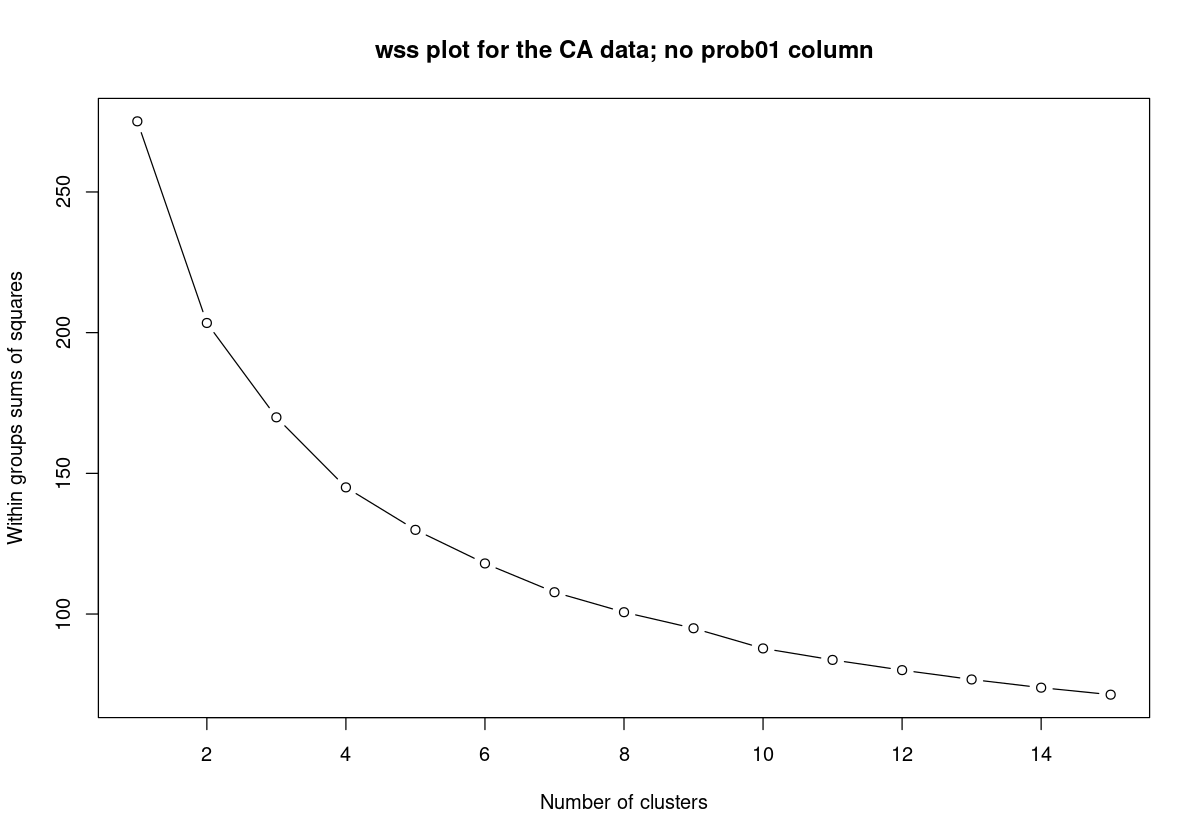

In [44]:
# See whether 2 clusters makes sense for this dataframe.

options(repr.plot.width= 10, repr.plot.height= 7)

wssplot(kmtrain_scaled[, -1], title= "wss plot for the CA data; no prob01 column")


In [ ]:
### COMMENT:

# The above plot shows no obvious "kink" in the curve.

# It is not at all clear that 2 subgroups
# are optimal.  3 would seem to work just as well.
# This is interesting because, as seen above, op_transf
# (a variable removed from the current dataset) has 3 
# levels: OCEAN, INLAND, and NEAR BAY.  op_transf is a 
# categorical variable that is a transformation of 
# ocean_proximity, which has 4 levels: OCEAN, NEAR OCEAN,
# NEAR BAY, and INLAND.  In the AnalyzeCAhousingData set 
# of Jupyter notebooks, I found that NEAR OCEAN and OCEAN
# are enough alike (in terms of predicting median_house_value)
# that they ought to be reduced to a single level.

# In any case, for this dataset, it is clear that, 
# unlike the downer cow data, there is not a natural
# ordering into 2 subgroups.  Recall that with the cow data
# the specific purpose of collecting variables such as 
# AST and CK was to see if they could help predict surviving
# cows from non-survivors.  By contrast, the CA housing 
# variables I am working with were not collected with the 
# purpose of distinguishing Inland districts from districts
# closer to the ocean.  So it is reasonable to expect that
# there would be no obvious kink in the above curve.


## Construct k-means model with prob01 from rfclf_best

In [61]:
# Add a prob01 column to kmtrain.

preds <- predict(rfclf_best, newdata=traindat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtrain_scaled$prob01 <- preds[, 2]
summary(kmtrain_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

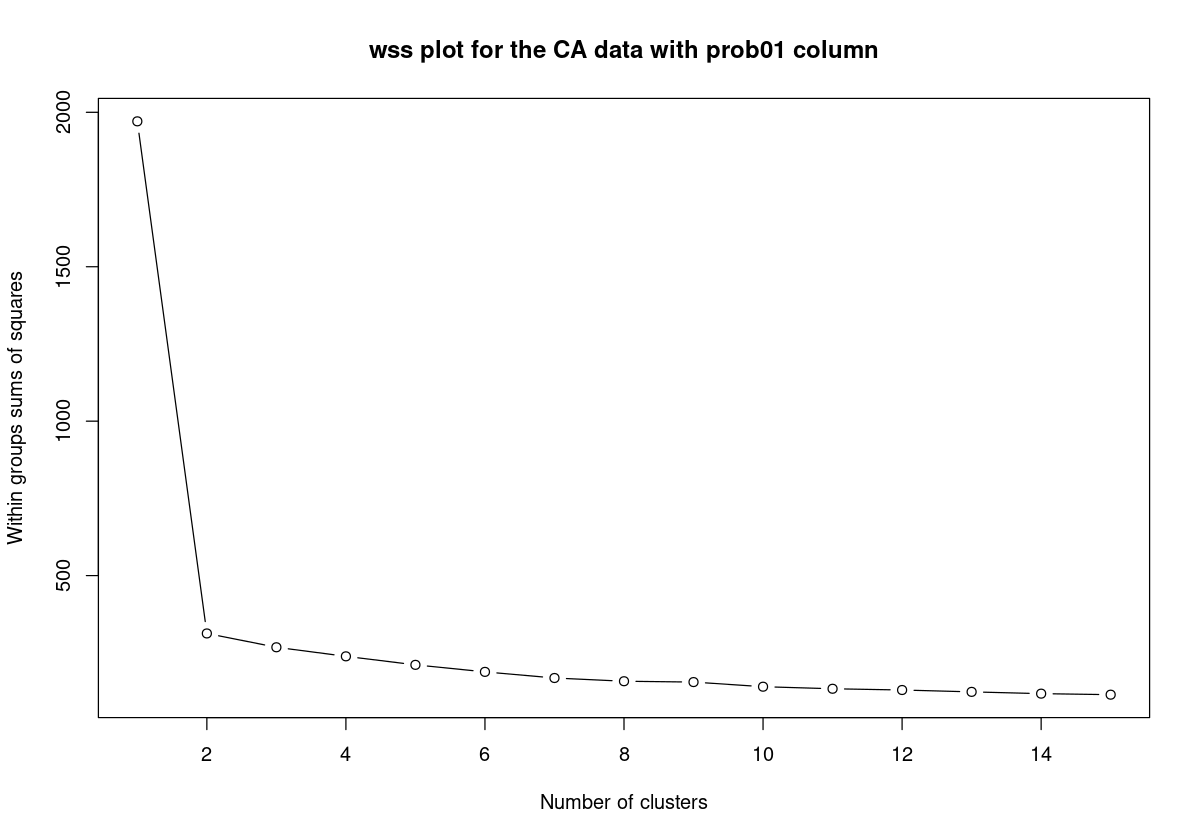

In [54]:
# See if a 2-cluster solution now makes more sense.

options(repr.plot.width= 10, repr.plot.height= 7)

suppressMessages(wssplot(kmtrain_scaled[, -1], 
        title= "wss plot for the CA data with prob01 column"))


In [ ]:
### COMMENT:

# This is exactly the kind of curve we want to see if
# we want to partition the data into 2 clusters.


### Get scores on trainset for k-means with prob01, no weights

In [62]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1 <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.03 secs

print(kmp1$size)


Time difference of 0.03 secs

[1] 6947 3249


In [63]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain_scaled$Inland, kmp1$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain_scaled)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans with prob01, trainset: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans with prob01, trainset: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


     0    1 class.error
0 6947    0           0
1    0 3249           0


[1] ""

[1] "f-score for kmeans with prob01, trainset: 1"


[1] ""

[1] "Type2 score for kmeans with prob01, trainset: 1"


[1] ""

[1] "Accuracy: 1"


### Get scores on testset for k-means with prob01, no weights

In [64]:
# Add a prob01 column to testdat.

kmtest <- testdat

preds <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtest$prob01 <- preds[, 2]


In [65]:
kmp1$centers


,pc1,pc2,pc3,pc4,prob01
1,0.31507,0.30647,0.20443,0.46747,0.045566
2,0.35892,0.38838,0.18692,0.41122,0.903993


In [66]:
# Function for obtaining a set of scores on the testset data
# using kmp1 as the classifier.

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1 <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1 from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 column.
        
        # Using model pca (constructed from the training set).
        df_pca <- predict(pca, df[, km_predictors])
        df02 <- cbind(as.data.frame(df_pca), df$prob01)
        
        # Apply min-max scaling to df02.
        df02_scaled <- apply(df02, MARGIN=2, range01)
        df02_scaled <- as.data.frame(df02_scaled,
                                     row.names=rownames(df))
        colnames(df02_scaled) <- colnames(kmp1$centers)
        
        
        # Each element of the following list is a row of df.
        df02_asList <- split(df02_scaled[, colnames(kmp1$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df02_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [67]:
# Get kmp1's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.81 mins


[1] "Start time: 2021-04-27 22:10:36"

Time difference of 7.81 mins

In [68]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8348,0.8960,0.8593,226,190
1953,0.8437,0.8995,0.8660,215,187
7591,0.8325,0.8928,0.8566,259,170
1038,0.8364,0.8985,0.8612,231,175
49,0.8326,0.8922,0.8564,229,202
3203,0.8362,0.8968,0.8604,225,188


In [69]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8348
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0061
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8348"

[1] "fscore StdDev: 0.0061"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.831   0.835   0.835   0.839   0.852 

In [70]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8957
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8957"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.886   0.893   0.895   0.896   0.898   0.908 

In [71]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8592
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.005
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8592"

[1] "Type2 StdDev: 0.005"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.847   0.856   0.859   0.859   0.862   0.874 

In [72]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 233.07
paste0("FN StdDev: ", as.character(FN_sd))
#  11.34
""
summary(dat_result$FN)


[1] "FN mean: 233.07"

[1] "FN StdDev: 11.34"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    195     225     233     233     240     262 

In [73]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 184.21
paste0("FP StdDev: ", as.character(FP_sd))
#  10.59
""
summary(dat_result$FP)


[1] "FP mean: 184.21"

[1] "FP StdDev: 10.59"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    157     175     185     184     192     210 

### Comments on kmp1, no weights

The kmp1 model is competitive with rfclf_best, our current best model.  On the testset data, rfclf_best has an accuracy score of 0.8979; for kmp1, this score is 0.8957.  rfclf_best has a Type2 score of 0.8611; for kmp1, this score is 0.8592.

We should be able to improve the kmp1 model using weights obtained through cross-validation.

# Section 3: Use 5 principal components with prob01, no weights

See if we can improve the k-means model by adding a fifth principal component.  The downside of doing this is the additional effort involved in finding optimal weights.  However, if we get a noticeable improvement over the rfclf_best model, we can perhaps forego the weights.

In [19]:
pca5 <- prcomp(traindat[, km_predictors], center=TRUE, scale.=TRUE,
              rank.=5, retx=TRUE)
summary(pca5)


Importance of first k=5 (out of 6) components:
                         PC1   PC2   PC3   PC4    PC5
Standard deviation     1.415 1.203 0.974 0.845 0.7200
Proportion of Variance 0.334 0.241 0.158 0.119 0.0864
Cumulative Proportion  0.334 0.575 0.733 0.852 0.9383

In [21]:
kmtrain <- cbind(traindat$Inland, as.data.frame(pca5$x))
rownames(kmtrain) <- rownames(traindat)
colnames(kmtrain) <- c("Inland","pc1","pc2","pc3","pc4","pc5")
head(kmtrain)


,Inland,pc1,pc2,pc3,pc4,pc5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.62155,-0.40828,0.78395,0.02940,-0.606426
1542,0,1.55471,-0.36770,0.39013,1.04186,-0.262446
3537,0,-1.06642,0.42280,-1.37004,0.98605,-0.119789
12747,1,0.23624,0.76784,-0.98573,1.35681,-0.857062
13348,1,-0.87807,0.12463,0.52692,-0.97772,-0.747739
6628,0,-1.51037,-0.42055,-1.56922,0.36121,0.092308


### Construct initial k-means model

In [22]:
# Apply min-max scaling to reduce the effects of the
# more extreme values.

kmtrain_scaled <- apply(kmtrain[, -1], MARGIN=2, range01)
kmtrain_scaled <- as.data.frame(cbind(as.numeric(kmtrain$Inland), kmtrain_scaled),
                                row.names=rownames(kmtrain))
colnames(kmtrain_scaled) <- colnames(kmtrain)


In [24]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [26]:
# Add a prob01 column to kmtrain.

preds <- predict(rfclf_best, newdata=traindat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtrain_scaled$prob01 <- preds[, 2]
summary(kmtrain_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

### Get scores on trainset for k-means with prob01, no weights

In [28]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1 <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
# round(stop - start, 2)
# Time difference of 0.03 secs

print(kmp1$size)


[1] 6947 3249


In [29]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain_scaled$Inland, kmp1$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain_scaled)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans with prob01, trainset: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans with prob01, trainset: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


     0    1 class.error
0 6947    0           0
1    0 3249           0


[1] ""

[1] "f-score for kmeans with prob01, trainset: 1"


[1] ""

[1] "Type2 score for kmeans with prob01, trainset: 1"


[1] ""

[1] "Accuracy: 1"


### Get scores on testset for k-means with prob01, no weights

In [30]:
# Add a prob01 column to testdat.

kmtest <- testdat

preds <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtest$prob01 <- preds[, 2]


In [31]:
kmp1$centers


,pc1,pc2,pc3,pc4,pc5,prob01
1,0.31507,0.30647,0.20443,0.46747,0.41426,0.045566
2,0.35892,0.38838,0.18692,0.41122,0.38720,0.903993


In [34]:
# Function for obtaining a set of scores on the testset data
# using kmp1 as the classifier.  Here 5 principal components
# are being used.

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1b <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1 from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 column.
        
        # Using model pca5 (constructed from the training set).
        df_pca <- predict(pca5, df[, km_predictors])
        df02 <- cbind(as.data.frame(df_pca), df$prob01)
        
        # Apply min-max scaling to df02.
        df02_scaled <- apply(df02, MARGIN=2, range01)
        df02_scaled <- as.data.frame(df02_scaled,
                                     row.names=rownames(df))
        colnames(df02_scaled) <- colnames(kmp1$centers)
        
        
        # Each element of the following list is a row of df.
        df02_asList <- split(df02_scaled[, colnames(kmp1$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df02_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [35]:
# Get kmp1's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1b(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.47 mins


[1] "Start time: 2021-04-25 18:04:45"

Time difference of 8.47 mins

In [37]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8348
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.006
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8348"

[1] "fscore StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.831   0.835   0.835   0.839   0.852 

In [38]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8957
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8957"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.887   0.893   0.896   0.896   0.898   0.908 

In [39]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8592
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.005
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8592"

[1] "Type2 StdDev: 0.005"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.847   0.856   0.859   0.859   0.862   0.874 

In [40]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 233.9
paste0("FN StdDev: ", as.character(FN_sd))
#  11.4
""
summary(dat_result$FN)


[1] "FN mean: 233.9"

[1] "FN StdDev: 11.4"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    196     226     234     234     241     262 

In [41]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 183.13
paste0("FP StdDev: ", as.character(FP_sd))
#  10.38
""
summary(dat_result$FP)


[1] "FP mean: 183.13"

[1] "FP StdDev: 10.38"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    156     175     184     183     190     210 

In [ ]:
### COMMENT:

# There is NO improvement when using the 5th 
# principal component.


# Section 4: Find optimal weights for kmp1 (4 principal components)

In what follows I first make use of the method worked out in the Addendum of Part 2, using tot.withinss to help find optimal weights (since relying on this surrogate score takes less time).  I find out, however, that this method does not work well for this dataset.  The problem might not be with the method itself, since I am not able to get any boost at all from the weights I identify and/or test below.  Perhaps the scaling that I am using (centering, scaling, then applying min-max) on the columns, in combination with the large number of records, makes weights superfluous.

In [47]:
# Function for computing the tot.withinss for each set of 
# weights in df_params (a dataframe, each row of which is
# a candidate set of weights).  The optimal set of weights
# will be the set that yields the smallest average (over
# the folds) for tot.withinss.
# This function is called from gridSearch07.

get_tot.withinss_rfclf <- function(traindat, valdat, wghts) {
    
    # Apply pca to traindat (4 components).
    pca <- prcomp(traindat[, km_predictors], center=TRUE, scale.=TRUE,
                  rank.=4, retx=FALSE)
    
    # Construct random forest model.
    set.seed(1493)
    rfclf <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900, mtry= 3, nodesize= 1)
    
    #############################
    # Prepare valdat.
    #############################
    
    # Apply pca.
    tmpdat <- predict(pca, valdat[, km_predictors])
    
    # Apply min-max scaling.
    valdat_scaled <- apply(tmpdat, MARGIN=2, range01)
    valdat_scaled <- as.data.frame(valdat_scaled)
    colnames(valdat_scaled) <- paste0("pc", 1:4)
    
    # Add prob01 column.
    preds_val <- predict(rfclf, newdata= valdat[, rfclf_columns], type="prob")
    valdat_scaled$prob01 <- preds_val[, 2]
    
    # Apply weights.
    cols <- names(wghts)
    valdat_wghts <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    
    # Construct k-means model on valdat to get tot.withinss.
    kmod <- suppressWarnings(kmeans(valdat_wghts, 2, iter.max = 50, nstart=5))
    
    return(kmod$tot.withinss)
}


In [48]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.

gridSearch07 <- function(seed_vector, dat, df_params, folds=7) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "tot.withinss")
    datout$row <- params_rows <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    #############################
    # Partition the data into folds.
    
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are tot.withinss 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(k in 1:folds) {
            endpt <- startpt + segmentsv[k] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[k]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            scores <- mcmapply(get_tot.withinss_rfclf, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=7)
            
            # For the current seed, store the average of the tot.withinss
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the tot.withinss scores
    # obtained for each set of parameters in df_params.
    datout$tot.withinss <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [49]:
# There are 5 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.12, 0.28, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  3951     5


[1] 3951    5

In [42]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
37613,0.14,0.18,0.22,0.24,0.22
34757,0.26,0.12,0.24,0.16,0.22
18669,0.16,0.20,0.22,0.26,0.16
17805,0.16,0.26,0.18,0.24,0.16
19845,0.28,0.28,0.14,0.12,0.18
46709,0.26,0.22,0.12,0.14,0.26


In [37]:
# Find the best weights of those in tst_params.

set.seed(1221)
seed_vector <- sample(1:9999, 3, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.42 mins (for 10 rows, 3 seeds, 5 folds per)


Time difference of 3.42 mins

In [43]:
# Run the test again with only 1 seed, but 10 folds and
# using 10 cores.

set.seed(1221)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.13 mins


Time difference of 2.13 mins

In [50]:
# Run the test again with only 1 seed, but 7 folds and
# using 7 cores.

set.seed(1221)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.7 mins


Time difference of 1.69 mins

In [51]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [52]:
dfc01[best_params,]

best_tot.withinss


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21093,0.22,0.18,0.28,0.14,0.18


[1] 13.47

In [53]:
# Find the best weights of those in dfc01 (3951 rows,
# 1 seed, 7 folds). 

set.seed(1221)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, traindat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 11.29 hours.


[1] "Start time: 2021-04-25 22:20:20"

Time difference of 11.29 hours

In [54]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [55]:
dfc01[best_params,]
# 693    0.28   0.20   0.28   0.12   0.12

best_tot.withinss
# 12.61


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
693,0.28,0.2,0.28,0.12,0.12


[1] 12.61

In [56]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- seq(0.26, 0.36, by=0.02)
lst[[2]] <- seq(0.16, 0.24, by=0.02)
lst[[3]] <- seq(0.26, 0.36, by=0.02)
lst[[4]] <- seq(0.06, 0.14, by=0.02)
lst[[5]] <- seq(0.06, 0.14, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  486     5


[1] 486   5

In [57]:
# Find the best weights of those in dfc01 (486 rows,
# 1 seed, 7 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, traindat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.39 hours.


[1] "Start time: 2021-04-26 09:45:09"

Time difference of 1.39 hours

In [58]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [59]:
dfc02[best_params,]
# 156    0.36   0.16   0.36   0.06   0.06

best_tot.withinss
# 10.59


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
156,0.36,0.16,0.36,0.06,0.06


[1] 10.59

In [60]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- seq(0.36, 0.40, by=0.02)
lst[[2]] <- seq(0.10, 0.16, by=0.02)
lst[[3]] <- seq(0.36, 0.40, by=0.02)
lst[[4]] <- seq(0.04, 0.06, by=0.02)
lst[[5]] <- seq(0.04, 0.06, by=0.02)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  30     5


[1] 30  5

In [61]:
# Find the best weights of those in dfc01 (30 rows,
# 1 seed, 7 folds). 

set.seed(1235)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, traindat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.12 mins.


[1] "Start time: 2021-04-26 11:13:16"

Time difference of 5.12 mins

In [62]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [63]:
dfc03[best_params,]
# 34    0.36   0.16   0.40   0.04   0.04

best_tot.withinss
# 11.43


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,0.36,0.16,0.4,0.04,0.04


[1] 11.43

In [64]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- seq(0.34, 0.37, by=0.01)
lst[[2]] <- seq(0.15, 0.17, by=0.01)
lst[[3]] <- seq(0.38, 0.41, by=0.01)
lst[[4]] <- seq(0.04, 0.06, by=0.01)
lst[[5]] <- seq(0.04, 0.06, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
#  71     5


[1] 71  5

In [65]:
# Find the best weights of those in dfc01 (71 rows,
# 1 seed, 7 folds). 

set.seed(245)
seed_vector <- sample(1:9999, 1, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, traindat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 12.33 mins.


[1] "Start time: 2021-04-26 11:23:39"

Time difference of 12.33 mins

In [66]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [67]:
dfc04[best_params,]
# 39    0.36   0.15   0.41   0.04   0.04

best_tot.withinss
# 11.5


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,0.36,0.15,0.41,0.04,0.04


[1] 11.5

### Test the weights using cross-validation

Here gridSearch06, rather than gridSearch07, is used.  Up to this point, we have been relying on a surrogate score to obtain optimal weights.  gridSearch06 relies on the Type2 score.

In [71]:
lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- c(0.36)
lst[[2]] <- c(0.15)
lst[[3]] <- c(0.41)
lst[[4]] <- c(0.04)
lst[[5]] <- c(0.04)

start <- Sys.time()
dfc05 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

# Try other nearby weights.
dfc05 <- rbind(dfc05, c(0.36, 0.16, 0.36, 0.06, 0.06))
dfc05 <- rbind(dfc05, c(0.28, 0.20, 0.28, 0.12, 0.12))
dfc05 <- rbind(dfc05, c(0.32, 0.18, 0.32, 0.09, 0.09))
dfc05


pc1,pc2,pc3,pc4,prob01
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.36,0.15,0.41,0.04,0.04
0.36,0.16,0.36,0.06,0.06
0.28,0.20,0.28,0.12,0.12
0.32,0.18,0.32,0.09,0.09


In [86]:
# Find the best weights of those in dfc05, 
# using 5 seeds.

set.seed(1933)
seed_vector <- sample(1:9999, 5, replace=FALSE)

start <- Sys.time()
paste("Start time:  ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.61 mins.


[1] "Start time:  2021-04-26 13:22:22"

Time difference of 2.61 mins

In [87]:
datout <- cbind(dfc05, dat_result$Type2)
colnames(datout) <- c(colnames(dfc05), "Type2")
datout


pc1,pc2,pc3,pc4,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.36,0.15,0.41,0.04,0.04,0.85494
0.36,0.16,0.36,0.06,0.06,0.85562
0.28,0.20,0.28,0.12,0.12,0.85566
0.32,0.18,0.32,0.09,0.09,0.85571


In [88]:
# Find the best weights of those in dfc05, 
# using 11 seeds.

set.seed(17)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time:  ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.84 mins.


[1] "Start time:  2021-04-26 13:29:11"

Time difference of 5.84 mins

In [89]:
datout <- cbind(dfc05, dat_result$Type2)
colnames(datout) <- c(colnames(dfc05), "Type2")
datout


pc1,pc2,pc3,pc4,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.36,0.15,0.41,0.04,0.04,0.85537
0.36,0.16,0.36,0.06,0.06,0.85618
0.28,0.20,0.28,0.12,0.12,0.85634
0.32,0.18,0.32,0.09,0.09,0.85625


In [90]:
# Remove the first set of weights since it
# is getting the lowest score.

dfc05 <- dfc05[2:4,]


In [91]:
# Find the best weights of those in dfc05, 
# using 51 seeds.

set.seed(17)
seed_vector <- sample(1:9999, 51, replace=FALSE)

start <- Sys.time()
paste("Start time:  ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 20.58 mins.


[1] "Start time:  2021-04-26 13:49:25"

Time difference of 20.58 mins

In [92]:
datout <- cbind(dfc05, dat_result$Type2)
colnames(datout) <- c(colnames(dfc05), "Type2")
datout


,pc1,pc2,pc3,pc4,prob01,Type2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.36,0.16,0.36,0.06,0.06,0.85625
3,0.28,0.20,0.28,0.12,0.12,0.85637
4,0.32,0.18,0.32,0.09,0.09,0.85639


In [ ]:
### COMMENT: 

# There is not much difference in average Type2 score
# among the different sets of weights.  It appears 
# that row 4 might be the best set.

# It is not at all clear that using tot.withinss works
# with this larger dataset.  It might also be the case
# that getting a cross-val score from 7 folds is not
# sufficient.

# In order to have a model that performs better than 
# our current best model, rfclf_best, I likely need
# an average cross-val Type2 score over 0.8610.

# wghts <- c(0.32, 0.18, 0.32, 0.09, 0.09)


In [17]:
lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- c(0.31)
lst[[2]] <- c(0.18)
lst[[3]] <- c(0.31)
lst[[4]] <- c(0.10)
lst[[5]] <- c(0.10)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

# Check that output from rep(0.20, 5) is same, or
# nearly the same, as output from rep(1, 5).
dfc06 <- rbind(dfc06, rep(1, 5))
dfc06 <- rbind(dfc06, rep(0.20, 5))

# Check the degree of difference in the Type2 score
# when we use weights which are NOT optimal.
dfc06 <- rbind(dfc06, c(0.24, 0.16, 0.20, 0.12, 0.28))
dfc06 <- rbind(dfc06, c(0.22, 0.14, 0.22, 0.14, 0.28))
dfc06

pc1,pc2,pc3,pc4,prob01
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.31,0.18,0.31,0.10,0.10
1.00,1.00,1.00,1.00,1.00
0.20,0.20,0.20,0.20,0.20
0.24,0.16,0.20,0.12,0.28
0.22,0.14,0.22,0.14,0.28


In [18]:
# Find the best weights of those in dfc06, 
# using 51 seeds.

set.seed(17)
seed_vector <- sample(1:9999, 51, replace=FALSE)

start <- Sys.time()
paste("Start time:  ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 36 mins.


[1] "Start time:  2021-04-27 19:06:53"

Time difference of 36.03 mins

In [19]:
datout <- cbind(dfc06, dat_result$Type2)
colnames(datout) <- c(colnames(dfc06), "Type2")
datout


pc1,pc2,pc3,pc4,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.31,0.18,0.31,0.10,0.10,0.85637
1.00,1.00,1.00,1.00,1.00,0.85632
0.20,0.20,0.20,0.20,0.20,0.85632
0.24,0.16,0.20,0.12,0.28,0.85643
0.22,0.14,0.22,0.14,0.28,0.85647


In [ ]:
### COMMENTS:

# The method of finding weights using tot.withinss
# clearly did not work for this dataset.  Part of 
# the issue might be that 5 folds are simply not 
# enough by which to judge the best set of weights.

# We can also see from the above table that a 
# significant change in the weights makes very 
# little difference in the average Type2 score.  So
# from the results I have thus far, it appears as 
# though using weights will not do much to improve
# our k-means hybrid model.


In [21]:
# Try one more set of weights, giving more weight to
# the prob01 column.

lst <- vector("list", length= 5)
names(lst) <- c(paste0("pc", 1:4),"prob01")

lst[[1]] <- c(0.20)
lst[[2]] <- c(0.14)
lst[[3]] <- c(0.20)
lst[[4]] <- c(0.14)
lst[[5]] <- c(0.32)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()

dfc06


,pc1,pc2,pc3,pc4,prob01
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2,0.14,0.2,0.14,0.32


In [22]:
# Find the best weights of those in dfc06, 
# using 51 seeds.

set.seed(17)
seed_vector <- sample(1:9999, 51, replace=FALSE)

start <- Sys.time()
paste("Start time:  ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.2 mins.


[1] "Start time:  2021-04-27 20:05:20"

Time difference of 7.19 mins

In [23]:
datout <- cbind(dfc06, dat_result$Type2)
colnames(datout) <- c(colnames(dfc06), "Type2")
datout


,pc1,pc2,pc3,pc4,prob01,Type2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.2,0.14,0.2,0.14,0.32,0.85644


### Get scores on trainset for hybrid model, using weights

In [25]:
pca4 <- prcomp(traindat[, km_predictors], center=TRUE, scale.=TRUE,
               rank.=4, retx=TRUE)
summary(pca4)


Importance of first k=4 (out of 6) components:
                         PC1   PC2   PC3   PC4
Standard deviation     1.415 1.203 0.974 0.845
Proportion of Variance 0.334 0.241 0.158 0.119
Cumulative Proportion  0.334 0.575 0.733 0.852

In [74]:
kmtrain <- cbind(traindat$Inland, as.data.frame(pca4$x))
rownames(kmtrain) <- rownames(traindat)
colnames(kmtrain) <- c("Inland","pc1","pc2","pc3","pc4")
head(kmtrain)


,Inland,pc1,pc2,pc3,pc4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.62155,-0.40828,0.78395,0.02940
1542,0,1.55471,-0.36770,0.39013,1.04186
3537,0,-1.06642,0.42280,-1.37004,0.98605
12747,1,0.23624,0.76784,-0.98573,1.35681
13348,1,-0.87807,0.12463,0.52692,-0.97772
6628,0,-1.51037,-0.42055,-1.56922,0.36121


In [75]:
# Apply min-max scaling to reduce the effects of the
# more extreme values.

kmtrain_scaled <- apply(kmtrain[, -1], MARGIN=2, range01)
kmtrain_scaled <- as.data.frame(cbind(as.numeric(kmtrain$Inland), kmtrain_scaled),
                                row.names=rownames(kmtrain))
colnames(kmtrain_scaled) <- colnames(kmtrain)


In [76]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [77]:
# Construct random forest model with specific seed.

# As we have seen previously, we get a slightly better
# model when we ask for the importances.

set.seed(1493)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900, mtry= 3, nodesize= 1,
                            importance= TRUE))
 


Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat[,      rfclf_columns], ntree = 900, mtry = 3, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.39%
Confusion matrix:
     0    1 class.error
0 6497  450    0.064776
1  609 2640    0.187442

In [78]:
# Add a prob01 column to kmtrain.

preds <- predict(rfclf_best, newdata=traindat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtrain_scaled$prob01 <- preds[, 2]
summary(kmtrain_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

In [79]:
# Apply our best weights.

wghts <- c(0.22, 0.14, 0.22, 0.14, 0.28)
names(wghts) <- cols <- c(paste0("pc", 1:4), "prob01")

kmtrain_wghts <- t(t(kmtrain_scaled[, cols]) * as.numeric(wghts[cols]))


In [80]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1 <- kmeans(kmtrain_wghts, 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
# round(stop - start, 2)
# Time difference of 0.03 secs

print(kmp1$size)


[1] 6947 3249


In [81]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain_scaled$Inland, kmp1$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain_scaled)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for hybrid model with weights, trainset: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for hybrid model with weights, trainset: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


     0    1 class.error
0 6947    0           0
1    0 3249           0


[1] ""

[1] "f-score for hybrid model with weights, trainset: 1"


[1] ""

[1] "Type2 score for hybrid model with weights, trainset: 1"


[1] ""

[1] "Accuracy: 1"


### Get scores on testset for hybrid model with weights

In [82]:
# Add a prob01 column to testdat.

kmtest <- testdat

preds <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")

# preds is a matrix with 2 columns.
kmtest$prob01 <- preds[, 2]


In [83]:
kmp1$centers


,pc1,pc2,pc3,pc4,prob01
1,0.069316,0.042905,0.044974,0.065446,0.012758
2,0.078962,0.054373,0.041123,0.057571,0.253118


In [84]:
# Function for obtaining a set of scores on the testset data
# using kmp1 as the classifier. 

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1b <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1 from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 column.
        
        # Using model pca4 (constructed from the training set).
        df_pca <- predict(pca4, df[, km_predictors])
        df02 <- cbind(as.data.frame(df_pca), df$prob01)
        
        # Apply min-max scaling to df02.
        df02_scaled <- apply(df02, MARGIN=2, range01)
        df02_scaled <- as.data.frame(df02_scaled,
                                     row.names=rownames(df))
        colnames(df02_scaled) <- colnames(kmp1$centers)
        
        # Apply weights to valdat.  wghts and cols are defined above.
        df02_wghts <- t(t(df02_scaled[, cols]) * as.numeric(wghts[cols]))
        
        
        # Each element of the following list is a row of df.
        df02_asList <- split(df02_wghts[, colnames(kmp1$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df02_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [85]:
# Get kmp1's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1b(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 27.6 secs


[1] "Start time: 2021-04-27 22:28:57"

Time difference of 27.6 secs

In [86]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8357,0.8968,0.8601,227,186
1953,0.8436,0.8995,0.8660,216,186
7591,0.8320,0.8925,0.8562,260,170
1038,0.8360,0.8985,0.8610,234,172
49,0.8320,0.8920,0.8560,231,201
3203,0.8359,0.8968,0.8603,227,186


In [87]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8349
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.006
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8349"

[1] "fscore StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.831   0.835   0.835   0.839   0.852 

In [88]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8959
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8959"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.886   0.893   0.896   0.896   0.898   0.908 

In [89]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8593
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.005
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8593"

[1] "Type2 StdDev: 0.005"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.847   0.856   0.859   0.859   0.862   0.874 

In [90]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 234.66
paste0("FN StdDev: ", as.character(FN_sd))
#  11.27
""
summary(dat_result$FN)


[1] "FN mean: 234.66"

[1] "FN StdDev: 11.27"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    197     227     235     235     242     261 

In [91]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 181.9
paste0("FP StdDev: ", as.character(FP_sd))
#  10.16
""
summary(dat_result$FP)


[1] "FP mean: 181.9"

[1] "FP StdDev: 10.16"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    157     174     183     182     189     210 

## Section 4 Comments

Adding weights to the model terms is not helping.  The model with weights is no better than the model without weights (this is the k-means model with prob01 constructed from rfclf_best and using 4 principal components).


It may be that weights are not helping to improve the model because we have so much data to work with.  The scaling, of course, also helps to make the weights less important.  


If weights are not helpful, we do not need PCA.  In other words, we can include more of the original variables in the model without having to worry much about increasing the computational cost.  Similarly, we can also see if adding a second probability column improves performance.  (It may be that we get a better model by applying PCA first.)



                                    * * * * *

# Section 5: k-means with prob1 & prob2; no pca, no weights

Here I use rfclf_best for the prob01 column and svm02 for the prob02 column.  These are our current best models, as measured by accuracy and f-score.  rfclf_best has the highest numbers.  If the prob02 column is too highly correlated with the prob01 column, it will not help to improve the scores.

In [29]:
kmtrain <- traindat[, km_columns]
kmtest <- testdat[, km_columns]
colnames(kmtrain)


[1] "Inland"             "housing_median_age" "median_house_value"
[4] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[7] "pop_per_hh"

In [22]:
# Random forest model for the prob01 column:

set.seed(1493)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900,
                            mtry= 3, nodesize= 1, importance=TRUE))



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat[,      rfclf_columns], ntree = 900, mtry = 3, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.39%
Confusion matrix:
     0    1 class.error
0 6497  450    0.064776
1  609 2640    0.187442

In [30]:
# Add prob01 column.

preds01 <- predict(rfclf_best, newdata= traindat[, rfclf_columns], type="prob")

# preds01 is a matrix with 2 columns.
kmtrain$prob01 <- preds01[, 2]
summary(kmtrain$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

In [31]:
# Scale data for svm model.

svmtrain <- traindat[, svm02_columns]
svmtrain$median_house_value <- log(svmtrain$median_house_value)

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(as.numeric(svmtrain$Inland), svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [32]:
# SVM model for the prob02 column:

svm02 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
               gamma=0.06, cost=80, scale=FALSE, probability=TRUE)


In [33]:
# Construct prob02 column.

preds02 <- predict(svm02, newdata=svm_scaled, probability=TRUE)
kmtrain$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])
summary(kmtrain$prob02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0475  0.1017  0.3192  0.6861  0.9999 

In [34]:
# Initial scaling of kmtrain:

kmtrain_scaled <- scale(kmtrain[, -1])
centers <- attr(kmtrain_scaled, "scaled:center")
scales <- attr(kmtrain_scaled, "scaled:scale")


In [35]:
# Apply min-max scaling to reduce the effects of the
# more extreme values.

kmtrain_minmax <- apply(kmtrain_scaled, MARGIN=2, range01)
kmtrain_minmax <- as.data.frame(cbind(as.numeric(kmtrain$Inland), kmtrain_minmax),
                                row.names=rownames(kmtrain))
colnames(kmtrain_minmax) <- colnames(kmtrain)


In [36]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1p2 <- kmeans(kmtrain_minmax[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.15 secs

print(kmp1p2$size)


Time difference of 0.05 secs

[1] 7008 3188


In [37]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [38]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain$Inland, kmp1p2$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmp1p2, train set: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmp1p2, train set: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.5867"


     0    1 class.error
0 6722  225      0.0324
1  286 2963      0.0880


[1] ""

[1] "f-score for kmp1p2, train set: 0.9206"


[1] ""

[1] "Type2 score for kmp1p2, train set: 0.9323"


[1] ""

[1] "Accuracy: 0.9499"


### Get scores on testset for kmp1p2

In [39]:
# SVM scaling for testdat records.

svmtest <- testdat[, svm02_columns]
svmtest$median_house_value <- log(svmtest$median_house_value)

svmtest_scaled <- scale(svmtest[, -1], center= svm_centers, scale= svm_scales)
svmtest_scaled <- as.data.frame(cbind(as.numeric(svmtest$Inland), svmtest_scaled),
                                row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


In [40]:
# Add the prob01 and prob02 columns to testdat.  For prob02
# I am cheating a bit because the svm scaling is over all of
# testdat.  A more rigorous treatment would require separate
# scaling and predictions for each set of 4K records sampled
# from testdat in the get_testdatScores_kmp1p2 function below.

kmtest <- testdat[, km_columns]

preds01 <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")
preds02 <- predict(svm02, newdata=svmtest_scaled, probability=TRUE)


kmtest$prob01 <- preds01[, 2]
kmtest$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])


In [41]:
kmp1p2$centers


,housing_median_age,median_house_value,HHdens_ln,rooms_per_hh,bdrms_per_room,pop_per_hh,prob01,prob02
1,0.52657,0.34810,0.70255,0.11979,0.24111,0.12341,0.063744,0.095232
2,0.39732,0.14558,0.54147,0.13894,0.20998,0.12386,0.880459,0.811724


In [42]:
# Function for obtaining a set of scores on the testset data
# using kmp1p2 as the classifier. 

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1p2 <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1p2 from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1p2$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 & prob02 columns.
        
        # Scale df using the centers and scales from kmtrain_scaled.
        df_scaled <- scale(df[, -1], center=centers, scale=scales)
        
        # Apply min-max scaling to df_scaled.
        df02_scaled <- apply(df_scaled, MARGIN=2, range01)
        df02_scaled <- as.data.frame(df02_scaled,
                                     row.names=rownames(df))
        colnames(df02_scaled) <- colnames(kmp1p2$centers)
        
        
        # Each element of the following list is a row of df.
        df02_asList <- split(df02_scaled[, colnames(kmp1p2$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df02_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [43]:
# Get kmp1p2's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1p2(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 10.41 mins


[1] "Start time: 2021-04-30 08:58:41"

Time difference of 10.6 mins

In [44]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8346
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0059
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8346"

[1] "fscore StdDev: 0.0059"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.819   0.831   0.834   0.835   0.838   0.849 

In [45]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8962
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8962"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.887   0.894   0.896   0.896   0.898   0.907 

In [46]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8593
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0049
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8593"

[1] "Type2 StdDev: 0.0049"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.846   0.856   0.859   0.859   0.863   0.872 

In [47]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 240.4
paste0("FN StdDev: ", as.character(FN_sd))
#  11.4
""
summary(dat_result$FN)


[1] "FN mean: 240.35"

[1] "FN StdDev: 11.38"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    206     233     241     240     248     272 

In [48]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 174.7
paste0("FP StdDev: ", as.character(FP_sd))
#  9.7
""
summary(dat_result$FP)


[1] "FP mean: 174.72"

[1] "FP StdDev: 9.7"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    147     168     175     175     181     200 

## Section 5 Comments

The svm02 probabilities are neither helping nor hurting the k-means hybrid model.  If I had used PCA on the 6 predictors I might have gotten slightly better results, or slightly worse results; I do not think the difference would have been great.  

# Section 6: different approach using 2 prob columns

Here I continue to use 2 probability columns, one from rfclf_best, the other from svm02.  But I apply PCA to the 6 predictors and the svm02 probabilities.  I then add the probabilites from rfclf_best to the model.  

The reason for this approach: we saw in Part 2 that the svm02 probabilities did not mix well with those from the random forest model.  Although the dataset in Part 2 is completely different, something similar might be going on here (any complementary information might be nullified by conflicting information).  But the svm02 model is a better model than either f03 or gbclf_best, so if I am going to use a second set of probabilities, I want those from svm02.  If we transform the prob02 column using PCA, we might reduce any conflict existing between the prob01 and prob02 probabilities.


In [49]:
kmtrain <- traindat[, km_columns]
kmtest <- testdat[, km_columns]
colnames(kmtrain)


[1] "Inland"             "housing_median_age" "median_house_value"
[4] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[7] "pop_per_hh"

In [19]:
# Random forest model for the prob01 column:

set.seed(1493)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900,
                            mtry= 3, nodesize= 1, importance=TRUE))



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat[,      rfclf_columns], ntree = 900, mtry = 3, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.39%
Confusion matrix:
     0    1 class.error
0 6497  450    0.064776
1  609 2640    0.187442

In [50]:
# Scale data for svm model.

svmtrain <- traindat[, svm02_columns]
svmtrain$median_house_value <- log(svmtrain$median_house_value)

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(as.numeric(svmtrain$Inland), svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [51]:
# SVM model for the prob02 column:

svm02 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
               gamma=0.06, cost=80, scale=FALSE, probability=TRUE)


In [52]:
# Construct prob02 column.

preds02 <- predict(svm02, newdata=svm_scaled, probability=TRUE)
kmtrain$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])
summary(kmtrain$prob02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0479  0.1024  0.3196  0.6865  0.9999 

In [53]:
# Apply PCA.  Use 5 of the 7 components. 

pca <- prcomp(kmtrain[, c(km_predictors,"prob02")], center=TRUE, scale.=TRUE,
              rank.=5, retx=TRUE)
summary(pca)


Importance of first k=5 (out of 7) components:
                         PC1   PC2   PC3   PC4    PC5
Standard deviation     1.517 1.321 0.993 0.896 0.7397
Proportion of Variance 0.329 0.249 0.141 0.115 0.0782
Cumulative Proportion  0.329 0.578 0.719 0.834 0.9118

In [54]:
# Construct training set data for k-means modeling
# with PCA.

kmtrain02 <- cbind(as.numeric(traindat$Inland), as.data.frame(pca$x))
rownames(kmtrain02) <- rownames(traindat)
colnames(kmtrain02) <- c("Inland","pc1","pc2","pc3","pc4","pc5")
head(kmtrain02)


,Inland,pc1,pc2,pc3,pc4,pc5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,-0.050533,-0.92857,-0.762667,-0.18391,0.521402
1542,0,0.599497,-1.52889,-0.716347,0.95981,0.414506
3537,0,-1.037601,0.70059,0.893106,1.49712,0.152263
12747,1,1.167845,0.87609,0.734401,1.19491,1.266115
13348,1,-0.256596,0.87814,-0.090126,-1.32222,0.581090
6628,0,-1.620032,0.42692,1.467853,0.77186,-0.096807


In [55]:
# Apply min-max scaling.

kmtrain02_scaled <- apply(kmtrain02[, -1], MARGIN=2, range01)
kmtrain02_scaled <- as.data.frame(cbind(kmtrain02$Inland, kmtrain02_scaled),
                                row.names=rownames(kmtrain02))
colnames(kmtrain02_scaled) <- colnames(kmtrain02)
head(kmtrain02_scaled)


,Inland,pc1,pc2,pc3,pc4,pc5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.33699,0.53104,0.80673,0.45260,0.68716
1542,0,0.37827,0.48441,0.80902,0.63860,0.67339
3537,0,0.27430,0.65758,0.88845,0.72598,0.63961
12747,1,0.41437,0.67121,0.88062,0.67683,0.78309
13348,1,0.32390,0.67137,0.83993,0.26748,0.69485
6628,0,0.23731,0.63632,0.91682,0.60803,0.60753


In [56]:
# Add prob01 column.

preds01 <- predict(rfclf_best, newdata= traindat[, rfclf_columns], type="prob")

# preds01 is a matrix with 2 columns.
kmtrain02_scaled$prob01 <- preds01[, 2]
summary(kmtrain02_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

In [57]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1p2_b <- kmeans(kmtrain02_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.15 secs

print(kmp1p2_b$size)


Time difference of 0.03 secs

[1] 6947 3249


In [58]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [59]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain$Inland, kmp1p2_b$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmp1p2_b, train set: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmp1p2_b, train set: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


     0    1 class.error
0 6947    0           0
1    0 3249           0


[1] ""

[1] "f-score for kmp1p2_b, train set: 1"


[1] ""

[1] "Type2 score for kmp1p2_b, train set: 1"


[1] ""

[1] "Accuracy: 1"


### Get scores on testset for kmp1p2_b

In [60]:
# SVM scaling for testdat records.

svmtest <- testdat[, svm02_columns]
svmtest$median_house_value <- log(svmtest$median_house_value)

svmtest_scaled <- scale(svmtest[, -1], center= svm_centers, scale= svm_scales)
svmtest_scaled <- as.data.frame(cbind(as.numeric(svmtest$Inland), svmtest_scaled),
                                row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


In [61]:
# Add the prob02 column to kmtest.

kmtest <- testdat[, km_columns]
preds02 <- predict(svm02, newdata=svmtest_scaled, probability=TRUE)
kmtest$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])


In [62]:
# Add the prob01 column to kmtest.

preds01 <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")
kmtest$prob01 <- preds01[, 2]


In [63]:
kmp1p2_b$centers


,pc1,pc2,pc3,pc4,pc5,prob01
1,0.29971,0.57830,0.83920,0.50138,0.61212,0.045566
2,0.42677,0.65632,0.85543,0.44215,0.63683,0.903993


In [68]:
# Function for obtaining a set of scores on the testset data
# using kmp1p2_b as the classifier. 

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1p2_b <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1p2_b from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1p2_b$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 & prob02 columns.
        
        # Apply PCA.
        pca_columns <- c(km_predictors, "prob02")
        df_pca <- predict(pca, df[, pca_columns])
        
        # Apply min-max scaling to df_scaled.
        df_scaled <- apply(df_pca, MARGIN=2, range01)
        df_scaled <- as.data.frame(cbind(df_scaled, df$prob01),
                                   row.names=rownames(df))
        colnames(df_scaled) <- c(paste0("pc", 1:5),"prob01")
        
        
        # Each element of the following list is a row of df.
        df_asList <- split(df_scaled[, colnames(kmp1p2_b$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [71]:
# Get kmp1p2_b's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1p2_b(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.95 mins


[1] "Start time: 2021-04-30 09:41:09"

Time difference of 8.95 mins

In [72]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8365,0.8972,0.8608,226,185
1953,0.8456,0.9010,0.8678,216,180
7591,0.8323,0.8930,0.8566,263,165
1038,0.8357,0.8982,0.8607,234,173
49,0.8340,0.8935,0.8578,231,195
3203,0.8360,0.8970,0.8604,229,183


In [73]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8357
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0061
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8357"

[1] "fscore StdDev: 0.0061"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.832   0.836   0.836   0.839   0.851 

In [74]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8965
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8965"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.887   0.894   0.896   0.896   0.899   0.907 

In [75]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8600
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.005
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.86"

[1] "Type2 StdDev: 0.005"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.847   0.857   0.860   0.860   0.863   0.874 

In [76]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 234.6
paste0("FN StdDev: ", as.character(FN_sd))
#  11.5
""
summary(dat_result$FN)


[1] "FN mean: 234.62"

[1] "FN StdDev: 11.47"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    196     227     235     235     243     263 

In [77]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 179.5
paste0("FP StdDev: ", as.character(FP_sd))
#  10.3
""
summary(dat_result$FP)


[1] "FP mean: 179.48"

[1] "FP StdDev: 10.28"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    154     171     180     179     187     204 

## Section 6 Comments

The scores have improved with this approach, but we still do not have a better model than rfclf_best.  The F-statistic for the difference in accuracy scores between this approach and rfclf_best is 4.23.  So there is still a significant difference between the two models, meaning that rfclf_best is a slightly better model.

# Section 7: Use Section 6 approach, but with 4 principal components

With 4 components, rather than 5, there is less of a chance of overfitting the training set.  A model with only 4 components therefore might generalize better to the testset data.

In [78]:
kmtrain <- traindat[, km_columns]
kmtest <- testdat[, km_columns]
colnames(kmtrain)


[1] "Inland"             "housing_median_age" "median_house_value"
[4] "HHdens_ln"          "rooms_per_hh"       "bdrms_per_room"    
[7] "pop_per_hh"

In [19]:
# Random forest model for the prob01 column:

set.seed(1493)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat[, rfclf_columns], 
                            ntree=900,
                            mtry= 3, nodesize= 1, importance=TRUE))



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat[,      rfclf_columns], ntree = 900, mtry = 3, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 3

        OOB estimate of  error rate: 10.39%
Confusion matrix:
     0    1 class.error
0 6497  450    0.064776
1  609 2640    0.187442

In [79]:
# Scale data for svm model.

svmtrain <- traindat[, svm02_columns]
svmtrain$median_house_value <- log(svmtrain$median_house_value)

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(as.numeric(svmtrain$Inland), svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [80]:
# SVM model for the prob02 column:

svm02 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
               gamma=0.06, cost=80, scale=FALSE, probability=TRUE)


In [83]:
# Construct prob02 column.

preds02 <- predict(svm02, newdata=svm_scaled, probability=TRUE)
kmtrain$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])
summary(kmtrain$prob02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0479  0.1024  0.3196  0.6865  0.9999 

In [84]:
# Apply PCA.  Use 4 of the 7 components. 

pca4 <- prcomp(kmtrain[, c(km_predictors,"prob02")], center=TRUE, scale.=TRUE,
              rank.= 4, retx=TRUE)
summary(pca4)


Importance of first k=4 (out of 7) components:
                         PC1   PC2   PC3   PC4
Standard deviation     1.517 1.321 0.993 0.896
Proportion of Variance 0.329 0.249 0.141 0.115
Cumulative Proportion  0.329 0.578 0.719 0.834

In [85]:
# Construct training set data for k-means modeling
# with PCA.

kmtrain02 <- cbind(as.numeric(traindat$Inland), as.data.frame(pca4$x))
rownames(kmtrain02) <- rownames(traindat)
colnames(kmtrain02) <- c("Inland","pc1","pc2","pc3","pc4")
head(kmtrain02)


,Inland,pc1,pc2,pc3,pc4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,-0.050533,-0.92857,-0.762667,-0.18391
1542,0,0.599497,-1.52889,-0.716347,0.95981
3537,0,-1.037601,0.70059,0.893106,1.49712
12747,1,1.167845,0.87609,0.734401,1.19491
13348,1,-0.256596,0.87814,-0.090126,-1.32222
6628,0,-1.620032,0.42692,1.467853,0.77186


In [86]:
# Apply min-max scaling.

kmtrain02_scaled <- apply(kmtrain02[, -1], MARGIN=2, range01)
kmtrain02_scaled <- as.data.frame(cbind(kmtrain02$Inland, kmtrain02_scaled),
                                row.names=rownames(kmtrain02))
colnames(kmtrain02_scaled) <- colnames(kmtrain02)
head(kmtrain02_scaled)


,Inland,pc1,pc2,pc3,pc4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11174,0,0.33699,0.53104,0.80673,0.45260
1542,0,0.37827,0.48441,0.80902,0.63860
3537,0,0.27430,0.65758,0.88845,0.72598
12747,1,0.41437,0.67121,0.88062,0.67683
13348,1,0.32390,0.67137,0.83993,0.26748
6628,0,0.23731,0.63632,0.91682,0.60803


In [87]:
# Add prob01 column.

preds01 <- predict(rfclf_best, newdata= traindat[, rfclf_columns], type="prob")

# preds01 is a matrix with 2 columns.
kmtrain02_scaled$prob01 <- preds01[, 2]
summary(kmtrain02_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00889 0.04778 0.31911 0.83778 1.00000 

In [88]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1p2_b <- kmeans(kmtrain02_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.15 secs

print(kmp1p2_b$size)


Time difference of 0.04 secs

[1] 6947 3249


In [89]:
# Get percent of Inland districts in kmtrain.

kmtrain_Inland_percent <- mean(kmtrain$Inland)
round(kmtrain_Inland_percent, 4)


[1] 0.3187

In [90]:
# See how the clusters are associated with Inland.

dfout <- as.data.frame(cbind(kmtrain$Inland, kmp1p2_b$cluster))
colnames(dfout) <- c("Inland", "cluster")
rownames(dfout) <- rownames(kmtrain)
dat_c1 <- dfout[which(dfout$cluster== 1),]
datc1_Inland_percent <- mean(dat_c1$Inland)

tmpdat <- dfout

c1_to_InlandYES <- FALSE
if(datc1_Inland_percent >= kmtrain_Inland_percent) { c1_to_InlandYES <- TRUE }
        
if(c1_to_InlandYES) {
    # cluster 1 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
} else {
    # cluster 2 is associated with the Inland districts
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain[, "Inland", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmp1p2_b, train set: ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmp1p2_b, train set: ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


     0    1 class.error
0 6947    0           0
1    0 3249           0


[1] ""

[1] "f-score for kmp1p2_b, train set: 1"


[1] ""

[1] "Type2 score for kmp1p2_b, train set: 1"


[1] ""

[1] "Accuracy: 1"


### Get scores on testset for kmp1p2_b

In [91]:
# SVM scaling for testdat records.

svmtest <- testdat[, svm02_columns]
svmtest$median_house_value <- log(svmtest$median_house_value)

svmtest_scaled <- scale(svmtest[, -1], center= svm_centers, scale= svm_scales)
svmtest_scaled <- as.data.frame(cbind(as.numeric(svmtest$Inland), svmtest_scaled),
                                row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


In [92]:
# Add the prob02 column to kmtest.

kmtest <- testdat[, km_columns]
preds02 <- predict(svm02, newdata=svmtest_scaled, probability=TRUE)
kmtest$prob02 <- as.numeric(attr(preds02, "probabilities")[, 2])


In [93]:
# Add the prob01 column to kmtest.

preds01 <- predict(rfclf_best, newdata=testdat[, rfclf_columns],
                          type="prob")
kmtest$prob01 <- preds01[, 2]


In [94]:
kmp1p2_b$centers


,pc1,pc2,pc3,pc4,prob01
1,0.29971,0.57830,0.83920,0.50138,0.045566
2,0.42677,0.65632,0.85543,0.44215,0.903993


In [97]:
# Function for obtaining a set of scores on the testset data
# using kmp1p2_b as the classifier. 

### NOTE: the value of c1_to_InlandYES from above is being  
### used in the following function.

get_testdatScores_kmp1p2_b <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1p2_b from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1p2_b$centers
    }
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # CAUTION: df has the prob01 & prob02 columns.
        
        # Apply PCA.
        pca_columns <- c(km_predictors, "prob02")
        df_pca <- predict(pca4, df[, pca_columns])
        
        # Apply min-max scaling to df_scaled.
        df_scaled <- apply(df_pca, MARGIN=2, range01)
        df_scaled <- as.data.frame(cbind(df_scaled, df$prob01),
                                   row.names=rownames(df))
        colnames(df_scaled) <- c(paste0("pc", 1:4),"prob01")
        
        
        # Each element of the following list is a row of df.
        df_asList <- split(df_scaled[, colnames(kmp1p2_b$centers)], seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        preds <- mcmapply(getCluster, df_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(preds)
    
        df$pred_Inland <- NA
        if(c1_to_InlandYES) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [98]:
# Get kmp1p2_b's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_kmp1p2_b(seed_vector, kmtest)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.23 mins


[1] "Start time: 2021-04-30 10:04:23"

Time difference of 8.23 mins

In [99]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.8356,0.8965,0.8600,225,189
1953,0.8456,0.9010,0.8678,216,180
7591,0.8327,0.8932,0.8569,262,165
1038,0.8362,0.8985,0.8611,233,173
49,0.8337,0.8932,0.8575,231,196
3203,0.8361,0.8970,0.8605,228,184


In [100]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.8355
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.006
""
summary(dat_result$fscore)


[1] "fscore mean: 0.8355"

[1] "fscore StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.821   0.831   0.836   0.836   0.839   0.852 

In [101]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8963
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0037
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8963"

[1] "accuracy StdDev: 0.0037"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.887   0.894   0.896   0.896   0.899   0.907 

In [102]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.8599
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.005
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.8599"

[1] "Type2 StdDev: 0.005"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.848   0.857   0.860   0.860   0.863   0.874 

In [103]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 234.2
paste0("FN StdDev: ", as.character(FN_sd))
#  11.4
""
summary(dat_result$FN)


[1] "FN mean: 234.18"

[1] "FN StdDev: 11.43"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    195     227     234     234     242     262 

In [104]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 180.5
paste0("FP StdDev: ", as.character(FP_sd))
#  10.2
""
summary(dat_result$FP)


[1] "FP mean: 180.53"

[1] "FP StdDev: 10.18"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    156     173     181     181     189     206 

## Section 7 Comments

The scores in Section 7 are essentially equivalent to those in Section 6.  So there is no difference between the two approaches.

# Table Summarizing Part 3 Results

In [7]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part3_CAhousing.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  9 10

In [8]:
results


,fscore,fscore_sd,Type2,Type2_sd,accuracy,acc_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rfclf,0.8366,0.0060,0.8611,0.0049,0.8979,0.0037,242.3,11.6,166.0,9.8
gb,0.8204,0.0065,0.8475,0.0054,0.8882,0.0039,266.0,11.9,181.2,10.5
svm02,0.8265,0.0065,0.8536,0.0053,0.8943,0.0038,280.3,11.8,142.6,8.9
f03,0.7765,0.0076,0.8149,0.0060,0.8725,0.0042,401.6,14.3,108.6,8.4
kmp1_pca4,0.8348,0.0061,0.8592,0.0050,0.8957,0.0037,233.1,11.3,184.2,10.6
kmp1_pca4_wghts,0.8349,0.0060,0.8593,0.0050,0.8959,0.0037,234.7,11.3,181.9,10.2
kmp1p2,0.8346,0.0059,0.8593,0.0049,0.8962,0.0037,240.2,11.4,174.9,9.7
kmp1p2_pca5,0.8357,0.0061,0.8600,0.0050,0.8965,0.0037,234.6,11.5,179.5,10.3
kmp1p2_pca4,0.8355,0.0060,0.8599,0.0050,0.8963,0.0037,234.2,11.4,180.5,10.2


# Part 3 Final Comments

The k-means approach that produced better supervised learning models in Parts 1 and 2 is not yielding the same positive result for the California housing dataset.  For this dataset, our best k-means model still does not quite measure up to our best SL model (in this case, rfclf_best).  On average, rfclf_best classifies 5.6 more districts correctly out of 4K districts (0.14%) than does kmp1p2_pca5.  

When comparing the results of Part 3 with those from Parts 1 and 2, it is important to keep in mind that the predictors used in Part 3 were not collected with the aim of distinguishing between INLAND and OCEAN districts; whereas with the cow data, the predictors were specifically chosen to help distinguish between survivors and non-survivors.  One of the implications of this is that our first k-means models in Parts 1 and 2, absent any probability columns, were very competitive with the very best SL models.  I was then able to add the probabilities from one or more of the best SL models, employ weights, and get an even stronger model.  Here in Part 3, though, I start with a very weak k-means "base" model.  It is not competitive until I add the prob01 column.  Applying weights is not able to boost the score in any significant way.  Adding a second probability column also did not make an important positive difference.

The results of Part 3 should thus not be seen as a mark against the k-means hybrid approach to model construction.  We shouldn't expect the hybrid approach to always provide us with the strongest model.


The above work with weights is important.  The more predictors we have, the more difficult it is to search the parameter space for the optimal weights.  This difficulty increases as the number of records in our dataset increases.  We saw above, however, that this search may not always be necessary.  But more work is required in order to find out the conditions which, if satisfied, make a search for weights superfluous.
